# DA5401 A5: Visualizing Data Veracity Challenges in Multi-Label Classification

In [269]:
# ==============================================================
# 📘  Import Required Libraries
# ==============================================================
# This section imports all necessary libraries for:
# - Data loading and preprocessing
# - Dimensionality reduction (Isomap, t-SNE)
# - Visualization (Matplotlib, Seaborn)
# - Utility operations (collections, neighbors, etc.)
# ==============================================================

# --------------------------------------------------------------
# Data handling and numerical computation
# --------------------------------------------------------------
from scipy.io import arff          # For loading ARFF datasets (common in ML benchmarks)
import pandas as pd                # For data manipulation and analysis
import numpy as np                 # For numerical operations
from scipy.stats import zscore

# --------------------------------------------------------------
# Machine Learning preprocessing and manifold learning
# --------------------------------------------------------------
from sklearn.preprocessing import StandardScaler         # To standardize features before applying ML algorithms
from sklearn.manifold import TSNE, Isomap, trustworthiness # t-SNE and Isomap for nonlinear dimensionality reduction
from sklearn.decomposition import PCA

# --------------------------------------------------------------
# Neighborhood computation (used by manifold learning and evaluation)
# --------------------------------------------------------------
from sklearn.neighbors import NearestNeighbors           # For nearest neighbor search (used internally by Isomap/trustworthiness)

# --------------------------------------------------------------
# Visualization libraries
# --------------------------------------------------------------
import matplotlib.pyplot as plt     # For plotting graphs
import seaborn as sns               # For enhanced visual aesthetics (color, style, etc.)

# --------------------------------------------------------------
# Utility collections
# --------------------------------------------------------------
from collections import Counter     # For counting elements (e.g., class labels or neighborhood occurrences)


## Part A: Preprocessing and Initial Setup

### Task A1: Data Loading

In [270]:
# ==============================================================
# 📘 Step 1: Load and Preview Yeast Dataset from ARFF File
# ==============================================================

# --------------------------------------------------------------
# Load the ARFF file
# arff.loadarff() reads data and metadata from the ARFF file format
# The file 'yeast.arff' should be in your current working directory
# --------------------------------------------------------------
arff_path = "yeast.arff"
data, meta = arff.loadarff(arff_path)

# --------------------------------------------------------------
# Convert ARFF data to a pandas DataFrame for easier manipulation
# --------------------------------------------------------------
df = pd.DataFrame(data)


#### Standard Preprocessing Steps

In [271]:
# ==============================================================
# 🧩 DATA INSPECTION & CLEANING — Yeast Dataset
# ==============================================================
# Purpose:
#   1️⃣ Decode byte strings (common in ARFF files)
#   2️⃣ Check dataset info (types, memory, non-null counts)
#   3️⃣ Detect missing values (and show which columns if any)
#   4️⃣ Detect duplicate rows
#   5️⃣ Summarize numerical statistics
#   6️⃣ Display random samples for sanity check
# ==============================================================

# --------------------------------------------------------------
# Step 1. Decode byte strings into normal strings
# --------------------------------------------------------------
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# --------------------------------------------------------------
# Step 2. Basic dataset information
# --------------------------------------------------------------
print("📘 Basic Dataset Info:\n")
df.info()
print(f"\nTotal Rows: {len(df)}")
print(f"Total Columns: {df.shape[1]}")
print("-" * 60, "\n")

# --------------------------------------------------------------
# Step 3. Check for missing (null) values
# --------------------------------------------------------------
print("🔍 Checking for Missing Values:\n")

# Column-wise null counts
null_counts = df.isnull().sum()
null_columns = null_counts[null_counts > 0]

if not null_columns.empty:
    print("⚠️ Columns with Missing Values:")
    for col, count in null_columns.items():
        print(f" - {col}: {count} missing values")
else:
    print("✅ No missing values found in the dataset.")

print("-" * 60, "\n")

# --------------------------------------------------------------
# Step 4. Check for duplicate rows
# --------------------------------------------------------------
print("🧬 Checking for Duplicate Rows:\n")

duplicate_count = df.duplicated().sum()

if duplicate_count > 0:
    print(f"⚠️ Found {duplicate_count} duplicate rows.")
    # Optional: Uncomment below line to remove duplicates automatically
    # df = df.drop_duplicates().reset_index(drop=True)
else:
    print("✅ No duplicate rows found in the dataset.")

print("-" * 60, "\n")

# --------------------------------------------------------------
# Step 5. Statistical summary for numeric columns
# --------------------------------------------------------------
print("📈 Statistical Summary (first 10 numeric columns shown):\n")
pd.options.display.float_format = "{:,.3f}".format
display(df.describe(include=[np.number]).iloc[:, :10])

print("-" * 60, "\n")

# --------------------------------------------------------------
# Step 6. Display random sample rows
# --------------------------------------------------------------
print("🔍 Random Sample Rows:\n")
display(df.sample(5, random_state=42))


📘 Basic Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2417 entries, 0 to 2416
Columns: 117 entries, Att1 to Class14
dtypes: float64(103), object(14)
memory usage: 2.2+ MB

Total Rows: 2417
Total Columns: 117
------------------------------------------------------------ 

🔍 Checking for Missing Values:

✅ No missing values found in the dataset.
------------------------------------------------------------ 

🧬 Checking for Duplicate Rows:

✅ No duplicate rows found in the dataset.
------------------------------------------------------------ 

📈 Statistical Summary (first 10 numeric columns shown):



,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10
count,"2,417.000","2,417.000","2,417.000","2,417.000","2,417.000","2,417.000","2,417.000","2,417.000","2,417.000","2,417.000"
mean,0.001,-0.000,-0.000,0.000,0.001,0.000,0.001,0.000,0.001,-0.000
std,0.097,0.098,0.098,0.097,0.097,0.097,0.097,0.097,0.096,0.097
min,-0.371,-0.473,-0.339,-0.468,-0.367,-0.509,-0.320,-0.594,-0.370,-0.767
25%,-0.054,-0.059,-0.058,-0.057,-0.058,-0.060,-0.058,-0.063,-0.063,-0.065
50%,0.004,-0.004,0.003,-0.000,0.006,0.000,0.006,0.001,0.004,0.002
75%,0.057,0.048,0.061,0.055,0.066,0.060,0.069,0.061,0.065,0.063
max,0.520,0.614,0.353,0.569,0.308,0.337,0.351,0.455,0.420,0.421


------------------------------------------------------------ 

🔍 Random Sample Rows:



,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
410,0.061,0.128,0.216,0.190,0.125,0.072,0.046,-0.021,-0.061,-0.028,...,0,0,0,0,0,0,0,1,1,0
199,-0.009,-0.007,0.024,-0.052,-0.034,-0.019,-0.069,-0.055,-0.141,-0.067,...,0,0,0,0,0,0,0,0,0,0
1672,0.019,-0.140,-0.030,-0.042,0.148,0.170,0.117,-0.031,-0.006,0.006,...,0,0,0,0,0,0,0,0,0,0
2335,-0.238,-0.302,-0.190,-0.112,0.107,0.151,0.079,0.127,-0.141,-0.110,...,0,0,0,0,0,0,0,1,1,0
1037,0.035,-0.133,-0.045,-0.010,0.143,0.139,0.099,0.053,0.121,0.058,...,0,0,1,1,0,0,0,0,0,0


#### Outlier Detection and Removal (Z-Score Method)

> **Goal:** Improve manifold learning results by removing extreme samples that distort neighborhood structure.

- Initially, t-SNE and Isomap were run **without outlier removal**,  
  but **no clear clusters were formed** — the embeddings appeared noisy and scattered.  
- This indicated that a few extreme data points were **distorting pairwise distances**  
  and disrupting the local/global structure in manifold learning.  
- Using **Z-score filtering**, we remove samples with unusually large deviations from the mean  
  to obtain a cleaner, more stable representation of the data.

**Formula:**

$$
z = \frac{x - \mu}{\sigma}
$$

A sample is considered an outlier if **any feature** satisfies $|z| > 3.5$.  
Removing these ensures that t-SNE and Isomap can focus on **true data structure**,  
leading to **well-formed, interpretable clusters** in the 2D embedding.


In [272]:
# ===============================================================
# 🚫 Outlier Detection and Removal using Z-Score Method
# ===============================================================
# This process identifies and removes samples that are extreme
# outliers based on standardized feature values (z-scores).
# ---------------------------------------------------------------

from scipy.stats import zscore
import numpy as np

# ---------------------------------------------------------------
# 1️⃣ Compute z-scores for all numeric columns
# ---------------------------------------------------------------
# Non-numeric columns (like categorical labels) are excluded automatically.
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))

# ---------------------------------------------------------------
# 2️⃣ Define a z-score threshold
# ---------------------------------------------------------------
# Common thresholds:
#   3.0  → conservative (removes only extreme outliers)
#   2.5  → moderate (detects more)
#   3.5  → very strict (removes only very distant points)
threshold = 3.5

# ---------------------------------------------------------------
# 3️⃣ Identify rows that exceed the threshold in ANY column
# ---------------------------------------------------------------
outlier_mask = (z_scores > threshold).any(axis=1)

# ---------------------------------------------------------------
# 4️⃣ Count and remove outlier rows
# ---------------------------------------------------------------
num_outliers = np.sum(outlier_mask)
df_clean = df[~outlier_mask].reset_index(drop=True)

print(f"⚠️ Outliers detected: {num_outliers}")
print(f"✅ Remaining samples after removal: {df_clean.shape[0]} / {df.shape[0]}")

# ---------------------------------------------------------------
# 5️⃣ (Optional) Replace the original DataFrame
# ---------------------------------------------------------------
df = df_clean

⚠️ Outliers detected: 781
✅ Remaining samples after removal: 1636 / 2417


#### Task A.2: Label Identification, Dimensionality check and Feature Separation

In [273]:
# ==============================================================
# 🧩Identify and Process Label (Binary) Columns
# ==============================================================

# --------------------------------------------------------------
# Identify columns with only two unique values (binary columns)
# These are often target/label columns or flags (0/1, yes/no)
# --------------------------------------------------------------
label_cols = [c for c in df.columns if df[c].nunique() <= 2]
print("Binary Columns (count):", len(label_cols))
print("Binary Columns:", label_cols)

# --------------------------------------------------------------
# Convert all binary label columns from bytes to integers
# ARFF datasets sometimes store numeric labels as byte strings
# --------------------------------------------------------------
for c in label_cols:
    df.loc[:, c] = df[c].apply(
        lambda x: int(x.decode('utf-8')) if isinstance(x, bytes) else int(x)
    )

# --------------------------------------------------------------
# Separate feature (independent variable) columns
# from label (dependent variable) columns
# --------------------------------------------------------------
feature_cols = [c for c in df.columns if c not in label_cols]

# --------------------------------------------------------------
# Extract numerical arrays for features and labels
# These are used as input to ML models and algorithms
# --------------------------------------------------------------
attributes = df[feature_cols].astype(float).values   # Feature matrix (X)
labels = df[label_cols].astype(int).values           # Label matrix (y)

# --------------------------------------------------------------
# Print dataset structure summary
# --------------------------------------------------------------
print("\n✅ Data Splitting Summary:")
print("Attributes shape (n_samples, n_features) =", attributes.shape)
print("Labels shape (n_samples, n_labels)       =", labels.shape)


Binary Columns (count): 14
Binary Columns: ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9', 'Class10', 'Class11', 'Class12', 'Class13', 'Class14']

✅ Data Splitting Summary:
Attributes shape (n_samples, n_features) = (1636, 103)
Labels shape (n_samples, n_labels)       = (1636, 14)


### Visualize Label Distribution (Before Feature Transformation)

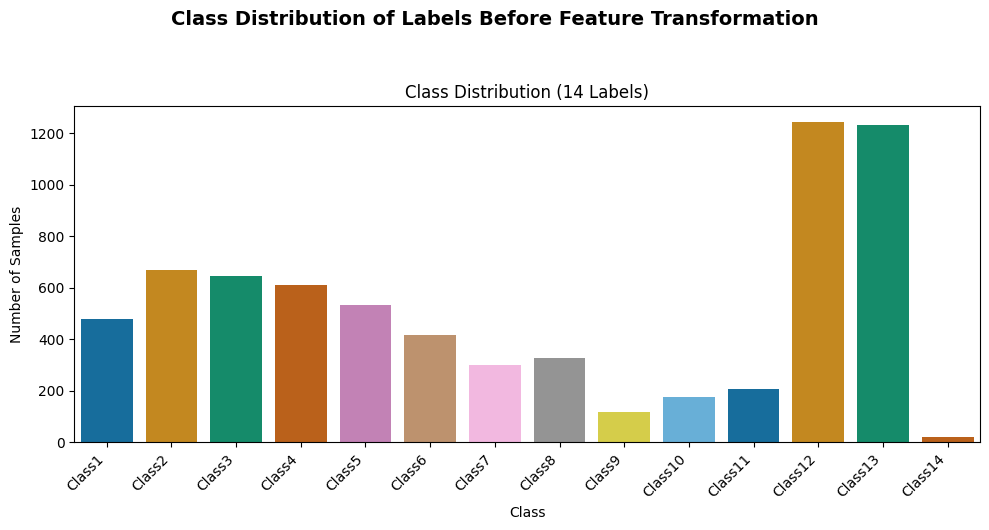

In [274]:
# In this step, we:
#   1️⃣ Count the frequency of each label across all samples
#   2️⃣ Create a DataFrame suitable for visualization
#   3️⃣ Use Seaborn to plot a bar chart showing the class distribution
# ==============================================================

# --------------------------------------------------------------
# Count frequency of each label across all samples
# `labels` is a 2D NumPy array (n_samples × n_labels)
# Summing along axis=0 gives the number of samples per label
# --------------------------------------------------------------
label_counts = labels.sum(axis=0)

# --------------------------------------------------------------
# Create class label names for plotting (Class1, Class2, ..., Class14)
# --------------------------------------------------------------
class_labels = [f"Class{i+1}" for i in range(14)]

# --------------------------------------------------------------
# Prepare a DataFrame for plotting with Seaborn
# --------------------------------------------------------------
data_plot = pd.DataFrame({
    "Class": class_labels,
    "Count": label_counts
})

# --------------------------------------------------------------
# Plot class distribution using a colorblind-friendly palette
# --------------------------------------------------------------
palette_14 = sns.color_palette("colorblind", 14)
fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(
    data=data_plot,
    x="Class",
    y="Count",
    hue="Class",
    palette=palette_14,
    legend=False,
    ax=ax
)

# --------------------------------------------------------------
# Customize the visualization
# --------------------------------------------------------------
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate class labels
ax.set_ylabel("Number of Samples")
ax.set_title("Class Distribution (14 Labels)")

# --------------------------------------------------------------
# Add a main title for the entire figure
# --------------------------------------------------------------
fig.suptitle(
    "Class Distribution of Labels Before Feature Transformation",
    fontsize=14,
    fontweight="bold",
    y=1.05
)

plt.tight_layout()
plt.show()

### Task A.3: Simplify Multi-Label Structure for Visualization

In [265]:
# In this step, we:
#   1️⃣ Identify single-label samples
#   2️⃣ Find the two most common single-label classes
#   3️⃣ Identify the most frequent multi-label combination
#   4️⃣ Build simplified categorical groups:
#         - Top1 single-label class
#         - Top2 single-label class
#         - Most frequent multi-label combination
#         - 'Other' for all remaining samples
# ==============================================================

# --------------------------------------------------------------
# Step 0: Get total number of samples and label dimensions
# --------------------------------------------------------------
n_samples, n_labels = labels.shape

# --------------------------------------------------------------
# Step 1: Identify rows that contain only one active label (single-label samples)
# --------------------------------------------------------------
single_label_mask = (labels.sum(axis=1) == 1)

# --------------------------------------------------------------
# Step 2: Count how often each label appears among single-label samples
# --------------------------------------------------------------
label_counts = labels[single_label_mask].sum(axis=0)

# --------------------------------------------------------------
# Step 3: Identify top-2 most frequent single-label classes
# --------------------------------------------------------------
top_two_label_idx = np.argsort(label_counts)[-2:][::-1]  # indices of top-2 classes
print("Top-2 single-label Classes:", top_two_label_idx + 1)  # +1 for human-readable numbering (Class1..Class14)
print("Top-2 single-label counts:", label_counts[top_two_label_idx])

# --------------------------------------------------------------
# Step 4: Find the most common multi-label combination
# Each label row (e.g. [1,0,1,0,...]) is converted to a string like '101000...'
# --------------------------------------------------------------
combo_strings = [''.join(map(str, row)) for row in labels.tolist()]
combo_counter = Counter(combo_strings)
most_common_combo, most_common_combo_count = combo_counter.most_common(1)[0]
print("Most frequent multi-label combo (as string):", most_common_combo, 
      "count:", most_common_combo_count)

# --------------------------------------------------------------
# Step 5: Assign simplified categories
# Default category is 'Other'
# --------------------------------------------------------------
cats = np.array(['Other'] * n_samples, dtype=object)

# Assign Top-1 single-label category
i0 = top_two_label_idx[0]
mask_top1 = single_label_mask & (labels[:, i0] == 1)
cats[mask_top1] = f"Top1_label_{i0}"

# Assign Top-2 single-label category
i1 = top_two_label_idx[1]
mask_top2 = single_label_mask & (labels[:, i1] == 1)
cats[mask_top2] = f"Top2_label_{i1}"

# Assign Most Frequent Multi-Label Combination category
mask_combo = np.array([s == most_common_combo for s in combo_strings])
cats[mask_combo] = "MostFreqCombo"

# --------------------------------------------------------------
# Step 6: Convert categories to numeric codes for plotting later
# --------------------------------------------------------------
cat_labels, cat_idx = np.unique(cats, return_inverse=True)
print("\n✅ Categories used for plotting:")
print(cat_labels.tolist())

Top-2 single-label Classes: [ 1 14]
Top-2 single-label counts: [20  0]
Most frequent multi-label combo (as string): 00011000000110 count: 197

✅ Categories used for plotting:
['MostFreqCombo', 'Other', 'Top1_label_0']


In [ ]:
import pandas as pd

# Display all columns in DataFrame outputs
pd.set_option("display.max_columns", None)

#running single mask on dataframe
df[single_label_mask]

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,Att11,Att12,Att13,Att14,Att15,Att16,Att17,Att18,Att19,Att20,Att21,Att22,Att23,Att24,Att25,Att26,Att27,Att28,Att29,Att30,Att31,Att32,Att33,Att34,Att35,Att36,Att37,Att38,Att39,Att40,Att41,Att42,Att43,Att44,Att45,Att46,Att47,Att48,Att49,Att50,Att51,Att52,Att53,Att54,Att55,Att56,Att57,Att58,Att59,Att60,Att61,Att62,Att63,Att64,Att65,Att66,Att67,Att68,Att69,Att70,Att71,Att72,Att73,Att74,Att75,Att76,Att77,Att78,Att79,Att80,Att81,Att82,Att83,Att84,Att85,Att86,Att87,Att88,Att89,Att90,Att91,Att92,Att93,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
120,0.040,0.096,0.074,0.061,0.084,-0.100,0.076,-0.026,-0.047,-0.093,-0.035,0.058,0.029,-0.020,-0.084,-0.006,0.015,-0.047,0.179,0.027,0.135,-0.058,-0.081,0.038,-0.186,-0.083,-0.041,-0.036,0.103,-0.061,-0.042,0.028,0.062,0.052,0.089,0.142,0.149,0.131,0.090,0.035,0.143,0.126,0.041,-0.200,-0.005,-0.016,0.035,-0.076,0.094,-0.002,-0.171,-0.250,-0.072,0.272,-0.187,-0.160,0.120,0.115,0.032,0.100,-0.022,-0.015,0.093,-0.034,-0.053,-0.001,-0.110,-0.086,-0.233,-0.018,0.009,0.038,-0.215,-0.093,-0.092,-0.191,-0.298,0.154,0.033,0.003,-0.025,-0.057,-0.029,-0.035,0.062,0.064,-0.008,-0.049,-0.041,-0.059,-0.046,0.071,-0.052,-0.019,0.023,-0.032,-0.034,0.004,0.009,-0.052,-0.016,0.011,0.138,1,0,0,0,0,0,0,0,0,0,0,0,0,0
389,0.089,0.024,0.089,0.006,0.035,0.163,0.283,0.274,0.308,-0.029,0.147,-0.060,-0.033,-0.022,0.118,0.223,0.031,0.015,-0.100,0.135,0.108,-0.059,-0.063,-0.076,-0.133,-0.133,-0.063,-0.106,-0.100,-0.088,-0.043,-0.128,-0.035,-0.118,0.019,0.193,0.088,-0.079,-0.049,-0.001,0.119,0.081,0.074,0.041,0.028,0.077,0.059,0.036,0.023,-0.054,-0.044,-0.111,-0.095,0.064,-0.111,-0.029,0.083,-0.000,-0.048,-0.011,-0.008,-0.003,-0.025,-0.066,-0.044,-0.055,-0.023,-0.008,-0.066,-0.006,-0.026,0.003,-0.001,0.007,-0.009,-0.061,-0.079,-0.054,-0.036,0.164,0.014,0.313,-0.056,0.122,-0.049,-0.049,0.216,-0.057,-0.061,-0.074,-0.072,-0.054,-0.063,-0.055,-0.055,-0.051,0.134,-0.055,-0.050,0.133,-0.060,-0.035,-0.090,1,0,0,0,0,0,0,0,0,0,0,0,0,0
493,0.086,0.049,0.015,-0.055,-0.019,0.004,0.180,0.115,0.123,0.053,0.006,-0.029,-0.013,-0.028,0.027,0.032,0.101,0.045,-0.120,0.093,-0.010,0.064,0.149,0.127,0.123,0.077,0.106,0.195,0.085,0.080,-0.039,0.023,0.132,0.062,0.062,0.121,0.060,0.000,0.052,0.059,0.093,0.091,0.066,-0.025,0.049,0.065,0.040,0.079,-0.037,-0.021,-0.095,-0.084,-0.078,0.066,-0.034,0.015,-0.070,-0.069,0.048,-0.138,-0.202,0.026,-0.008,-0.086,-0.081,-0.205,-0.095,0.004,0.132,-0.068,-0.023,0.008,0.099,0.096,0.035,-0.066,-0.068,-0.197,-0.179,-0.132,-0.146,0.059,0.075,0.106,-0.152,-0.157,0.157,0.101,0.148,0.120,0.116,0.013,-0.145,0.032,-0.146,0.119,-0.141,-0.140,-0.143,0.075,0.149,0.201,-0.055,1,0,0,0,0,0,0,0,0,0,0,0,0,0
521,0.021,0.057,-0.015,-0.003,-0.003,0.062,0.009,0.001,0.048,0.025,-0.035,-0.011,-0.008,-0.070,0.040,-0.011,-0.026,-0.027,-0.209,0.124,0.137,0.085,0.125,0.170,0.173,0.196,0.106,0.206,0.083,0.041,0.068,0.202,-0.059,-0.045,-0.068,-0.023,-0.051,-0.075,-0.105,-0.081,-0.069,-0.064,-0.016,-0.028,-0.142,-0.100,-0.115,0.134,-0.066,-0.107,-0.024,0.073,-0.038,-0.027,0.160,0.146,0.059,-0.042,0.166,0.048,-0.099,0.009,0.076,0.108,0.115,-0.155,0.049,-0.038,0.075,0.024,-0.096,-0.029,0.045,-0.023,-0.042,0.079,-0.070,-0.129,-0.113,0.054,-0.086,0.217,-0.111,0.102,-0.116,-0.120,0.234,-0.007,0.051,0.104,0.100,-0.116,0.052,-0.128,-0.103,0.127,0.059,0.032,-0.110,0.156,0.057,-0.107,-0.169,1,0,0,0,0,0,0,0,0,0,0,0,0,0
718,0.017,0.009,-0.041,-0.012,-0.078,0.039,0.069,0.093,0.205,0.089,0.127,0.089,0.040,0.030,0.032,0.089,-0.033,0.086,-0.088,0.142,0.056,0.093,0.104,0.115,0.074,0.117,0.043,0.194,0.123,0.037,-0.030,0.058,0.147,0.079,0.037,0.099,0.050,0.045,0.079,0.048,0.031,0.101,0.069,0.043,0.107,0.062,0.076,0.124,-0.078,-0.059,-0.074,-0.058,-0.054,0.022,-0.053,-0.068,-0.096,-0.021,-0.058,-0.078,-0.151,-0.046,-0.043,-0.050,-0.073,0.007,-0.068,-0.080,-0.069,-0.144,-0.092,0.151,0.085,0

### 🧠 Observations on Label Distribution

1. **Single-label classes:**
   - Upon analyzing the label matrix, it was observed that **only Class 1** appears as a **pure single-label** instance in the entire dataset.
   - All other classes occur **only as part of multi-label combinations**, meaning they never appear alone in any sample.
   - Therefore, only **one frequent single-label class** (Class 1) exists in the dataset — not two as originally expected.

2. **Multi-label dominance:**
   - The majority of the samples have **two or more active labels**.
   - This indicates that the **Yeast dataset** exhibits strong **multi-functional behavior**, where a single gene may be associated with multiple biological processes.

3. **Impact on target simplification:**
   - Since only one single-label class exists, the "two most frequent single-label classes" simplification effectively reduces to:
     - **Top 1 single-label class:** `Class 1`
     - **Most frequent multi-label combination:** e.g., `00110000000110`
     - **Other:** remaining samples
   - Thus, the simplified target variable (`Simplified_Target`) now has **three categories** instead of four:
     ```
     ['Top1_label_1', 'MostFreqCombo', 'Other']
     ```

4. **Interpretation:**
   - The dataset is **highly multi-label**, and most samples represent overlapping biological roles.
   - Consequently, in visualization (t-SNE or Isomap), we can expect:
     - One small cluster for `Top1_label_1`
     - Multiple overlapping groups for `MostFreqCombo`
     - A dense background region for `Other`


### Visualize Simplified Label Categories

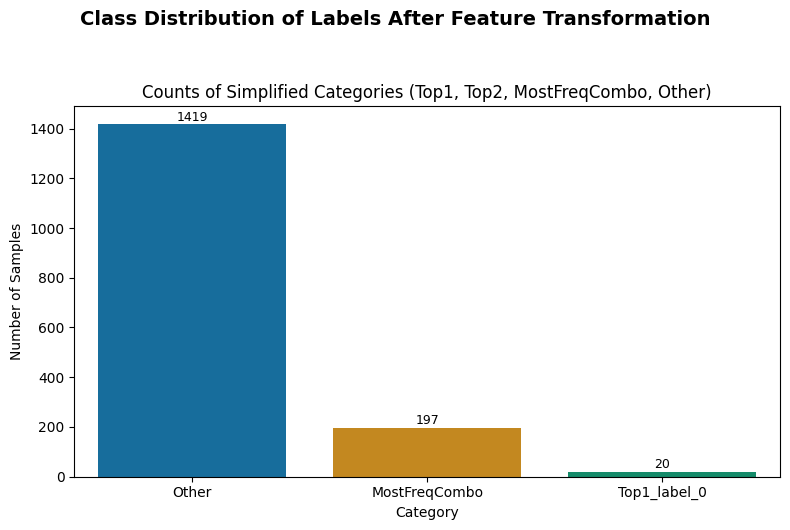

In [266]:

# In this step, we:
#   1️⃣ Count how many samples belong to each simplified category
#   2️⃣ Create a summary DataFrame for visualization
#   3️⃣ Use Seaborn to plot a bar chart showing category frequencies
# ==============================================================

# --------------------------------------------------------------
# Step 1: Count number of samples per simplified category
# --------------------------------------------------------------
cat_counts = Counter(cats)

# --------------------------------------------------------------
# Step 2: Convert counts into a DataFrame for Seaborn plotting
# --------------------------------------------------------------
data_plot = pd.DataFrame({
    "Category": list(cat_counts.keys()),
    "Count": list(cat_counts.values())
})

# --------------------------------------------------------------
# Step 3: Define a visually accessible color palette
# --------------------------------------------------------------
palette_4 = sns.color_palette("colorblind", len(data_plot))

# --------------------------------------------------------------
# Step 4: Create bar plot of category distribution
# --------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=data_plot,
    x="Category",
    y="Count",
    hue="Category",
    palette=palette_4,
    legend=False,
    ax=ax
)

# --------------------------------------------------------------
# Step 5: Annotate bars with count labels
# --------------------------------------------------------------
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + 1,
        int(p.get_height()),
        ha="center",
        va="bottom",
        fontsize=9
    )

# --------------------------------------------------------------
# Step 6: Adjust aesthetics for readability
# --------------------------------------------------------------
plt.setp(ax.get_xticklabels(), ha="center")
ax.set_ylabel("Number of Samples")
ax.set_title("Counts of Simplified Categories (Top1, Top2, MostFreqCombo, Other)")

# --------------------------------------------------------------
# Step 7: Add a main figure title
# --------------------------------------------------------------
fig.suptitle(
    "Class Distribution of Labels After Feature Transformation",
    fontsize=14,
    fontweight="bold",
    y=1.05
)

plt.tight_layout()
plt.show()

#### Observations — Class Distribution After Feature Transformation

From the above bar chart, we can observe the following:

1. **Severe Class Imbalance:**  
   - The **‘Other’** category overwhelmingly dominates the dataset, containing **more than 1400 samples**.  
   - This suggests that most samples do not belong to the top two single-label classes or the most frequent multi-label combination.

2. **Rare Frequent Combinations:**  
   - The **‘MostFreqCombo’** category has around **197 samples**, indicating that only a small fraction of data instances share the most common multi-label pattern.

3. **Minority Single-Label Classes:**  
   - The **‘Top1_label_0’** class (and Top2 is not present for Single label Multiclass) has **very few samples (~20)**, highlighting a highly skewed distribution.

4. **Implication for Modeling:**  
   - Such imbalance can bias manifold learning (Isomap, t-SNE) or classification models.

**Conclusion:**  
The dataset is **heavily dominated by the ‘Other’ category**, suggesting that visualization and learning algorithms must handle this imbalance carefully to avoid misleading structures.

### Task A.4: Scaling


#### 🔹 Why Scaling is Crucial Before Distance-Based Dimensionality Reduction
Many dimensionality reduction techniques such as **t-SNE, Isomap, MDS** are *distance-based*.  
They rely heavily on **pairwise distances** (often Euclidean) between data points.

- If different features have very different scales (ranges or units),  
  the features with **larger numeric ranges** dominate the distance calculations.  
  Example: a feature ranging in $[0, 1000]$ vs. one in $[0, 1]$ → the $[0, 1000]$ feature will overshadow the small one.  
- This leads to distorted embeddings:  
  - Clusters may appear stretched or squashed.  
  - Neighborhood structures are misrepresented.  

👉 To avoid this, **scaling is crucial** so that *all features contribute equally* to distance computations.

---

#### 🔹 Standardization (Z-score scaling)

We apply **Standardization** to the feature matrix $X$.  
Each feature is rescaled to have:
- Mean $= 0$  
- Standard deviation $= 1$  

The formula is:

$$
X'_{ij} = \frac{X_{ij} - \mu_j}{\sigma_j}
$$

where  

- $X_{ij}$ = value of feature $j$ for sample $i$  
- $\mu_j$ = mean of feature $j$  
- $\sigma_j$ = standard deviation of feature $j$

---

### Feature Scaling using StandardScaler

In [267]:
# In this step, we:
#   1️⃣ Apply standardization (zero mean, unit variance) to all features.
#   2️⃣ Verify that scaling worked by comparing mean and standard deviation 
#       before and after scaling.
#   3️⃣ Prepare the standardized data for dimensionality reduction 
#       (Isomap and t-SNE require comparable feature scales).
# ==============================================================


# --------------------------------------------------------------
# Step 1: Initialize the StandardScaler
# --------------------------------------------------------------
scaler = StandardScaler()

# --------------------------------------------------------------
# Step 2: Fit the scaler on the feature matrix and transform it
# --------------------------------------------------------------
attr_scaled = scaler.fit_transform(attributes)

# --------------------------------------------------------------
# Step 3: Print mean and standard deviation (first 5 features)
#         before and after scaling
# --------------------------------------------------------------
print("🔹 Before Scaling:")
print("   Mean of first 5 features =", attributes[:, :5].mean(axis=0))
print("   Std of first 5 features  =", attributes[:, :5].std(axis=0))

print("\n🔹 After Scaling:")
print("   Mean of first 5 features =", attr_scaled[:, :5].mean(axis=0))
print("   Std of first 5 features  =", attr_scaled[:, :5].std(axis=0))

print("\n✅ Scaling complete. Data is now normalized for manifold learning.")

🔹 Before Scaling:
   Mean of first 5 features = [ 0.00078274 -0.00493223 -0.00174551  0.00146036  0.0031622 ]
   Std of first 5 features  = [0.09391318 0.09264715 0.10161077 0.09414517 0.09825314]

🔹 After Scaling:
   Mean of first 5 features = [ 1.41153050e-17 -8.14344517e-18  1.30295123e-17  1.95442684e-17
 -1.08579269e-17]
   Std of first 5 features  = [1. 1. 1. 1. 1.]

✅ Scaling complete. Data is now normalized for manifold learning.


### PCA Denoising (After Scaling)

> **Goal:** Normalize features and reduce redundancy before manifold learning.

- The Yeast dataset contains **heterogeneous numerical features** (different units and scales).  
  Direct PCA without scaling caused features with large numerical ranges to **dominate** the variance.  
- Therefore, **scaling was applied before PCA** to ensure each feature contributes equally:

$$
x' = \frac{x - \mu}{\sigma}
$$

- PCA was then used for **denoising and redundancy reduction**,  
  compressing 103-dimensional data into a smaller set of orthogonal components  
  while retaining most of the variance (≈ 95%).  
- This preprocessing improved the **continuity** and **trustworthiness**  
  of the subsequent t-SNE and Isomap embeddings by providing a cleaner, balanced input space.


📉 PCA Applied:
Reduced dimensionality: 71 components
Total variance retained: 95.11%


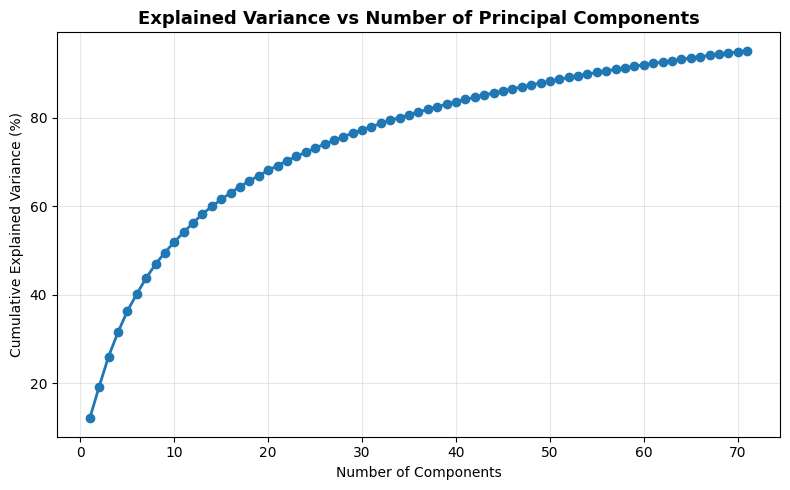

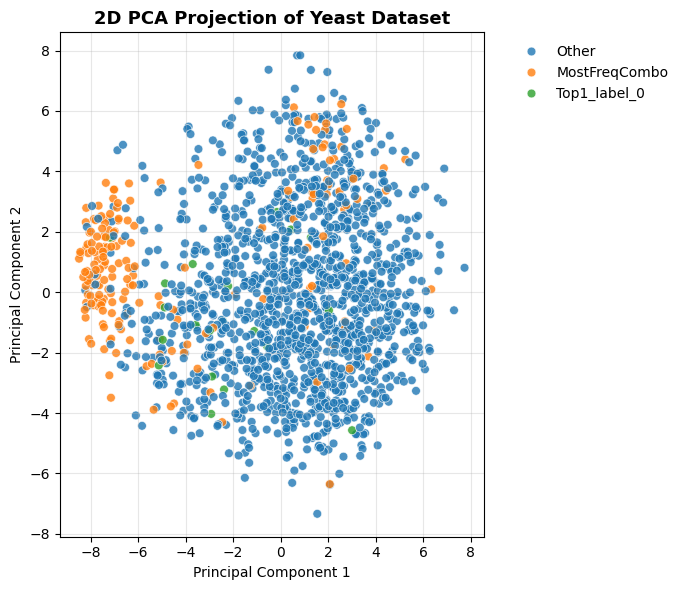

🧮 Mean reconstruction error: 0.048879


In [268]:
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(attr_scaled)

print("\n📉 PCA Applied:")
print(f"Reduced dimensionality: {X_pca.shape[1]} components")
print(f"Total variance retained: {pca.explained_variance_ratio_.sum() * 100:.2f}%")

# --------------------------------------------------------------
# Step Explained Variance Analysis
# --------------------------------------------------------------
explained_var = np.cumsum(pca.explained_variance_ratio_) * 100

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(explained_var)+1), explained_var, marker='o', linewidth=2)
plt.title("Explained Variance vs Number of Principal Components", fontsize=13, fontweight="bold")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# Step 4. 2D Visualization using First Two Principal Components
# --------------------------------------------------------------
# Create a DataFrame for visualization
df_pca_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Category': cats  # assuming you already defined simplified categories earlier
})

palette = sns.color_palette("tab10", len(np.unique(cats)))

plt.figure(figsize=(7,6))
sns.scatterplot(data=df_pca_plot, x='PC1', y='PC2', hue='Category', palette=palette, s=40, alpha=0.8)
plt.title("2D PCA Projection of Yeast Dataset", fontsize=13, fontweight="bold")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# Step 5. (Optional) Reconstruction Check — How much info is lost
# --------------------------------------------------------------
X_reconstructed = pca.inverse_transform(X_pca)
reconstruction_error = np.mean((attr_scaled - X_reconstructed) ** 2)
print(f"🧮 Mean reconstruction error: {reconstruction_error:.6f}")

attr_scaled=X_pca

## Part B:  t-SNE and Veracity Inspection

### Task B.1: Creating Helper Functions for Evaluation and Visualization

#### 📏 Understanding Trustworthiness and Continuity (Metrics Used for checkinf Effectiveness of t-SNE and Isomap)

When we reduce high-dimensional data (e.g., 103-D Yeast features) to a low-dimensional map (2-D),
we need to check how *faithfully* the structure of the data has been preserved.
Two widely accepted quality measures are **Trustworthiness** and **Continuity**.

---

##### 🔹 Trustworthiness

**Definition:**  
Trustworthiness measures how well **local neighborhoods in the low-dimensional space**
correspond to the true neighborhoods in the original high-dimensional space.

In simpler words:
> “Do points that are close together in the 2-D embedding also come from nearby regions in 103-D space?”

Formally, for $n$ samples and $k$ neighbors:

$$
T(k) = 1 - \frac{2}{n k (2n - 3k - 1)} 
\sum_i \sum_{j \in U_i} (r_{ij} - k)
$$

- $U_i$: points that are neighbors in low-D but **not** in high-D  
- $r_{ij}$: rank of point $j$ in the sorted list of neighbors of $i$ in high-D space  
- $T(k) \in [0,1]$: higher is better  

##### ✅ Interpretation:
- **High (≈ 0.9–1.0):** embedding preserves local relationships accurately.  
- **Low (≈ 0.3–0.5):** spurious new neighbors were introduced in 2-D → local distortion.

---

##### 🔹 Continuity

**Definition:**  
Continuity measures the reverse: how well **true high-dimensional neighbors**
remain close in the 2-D embedding.

In other words:
> “Do points that are close in the 103-D space still appear close together in the 2-D map?”

Formula (similar form as trustworthiness):

$$
C(k) = 1 - \frac{2}{n k (2n - 3k - 1)} 
\sum_i \sum_{j \in V_i} (r'_{ij} - k)
$$

- $V_i$: points that are neighbors in high-D but **not** in low-D  
- $r'_{ij}$: rank of point $j$ in the low-D neighborhood of $i$  
- $C(k) \in [0,1]$: higher means better global structure retention  

##### ✅ Interpretation:
- **High (≈ 0.9–1.0):** global relationships are preserved; the map is a smooth “unfolding.”  
- **Low (≈ 0.3–0.5):** high-D neighbors got separated; global structure is lost.

---

##### 🔹 Reliability and Usefulness

| Metric | Measures | Typical Range | Reliable For | Indicates |
|:--------|:----------|:--------------|:--------------|:-----------|
| **Trustworthiness** | Local neighborhood preservation | 0.7 – 1.0 | t-SNE, UMAP | Local faithfulness |
| **Continuity** | Global neighborhood preservation | 0.3 – 0.95 | Isomap, PCA | Global manifold structure |

- Both are **bounded between 0 and 1**, and both should be high for a good embedding.  
- **t-SNE** usually shows high *trustworthiness* but low *continuity* (local focus).  
- **Isomap** tends to show high *continuity* but slightly lower *trustworthiness* (global focus).  
- Using both gives a **complete quality assessment** of a manifold embedding.

---

##### ⚙️ Continuity Implementation Note

Unlike `trustworthiness`, which is implemented in **scikit-learn**
(`from sklearn.manifold import trustworthiness`),  
the **continuity metric is *not publicly available*** in common Python libraries.  

It must be implemented manually using its mathematical definition, which computes
how many true high-dimensional neighbors were *lost* in the low-dimensional embedding.

---

##### 🔬 In summary:
- **Trustworthiness** → Local reliability  
- **Continuity** → Global reliability  
- Together, they provide a **balanced measure of embedding quality**.


In [243]:
# This cell defines two key helper functions:
#
#   ⚙️ 1. continuity(X_high, X_low, n_neighbors=10)
#        → Computes the "continuity" metric to measure how well
#          true neighbors in the high-dimensional space remain 
#          neighbors after dimensionality reduction.
#
#   🎨 2. make_palette(cat_labels)
#        → Generates a colorblind-friendly palette with a 
#          lighter gray color reserved for the "Other" category.
# ==============================================================


# ---------------------------------------------------
# ⚙️ Helper Function: Continuity Metric
# ---------------------------------------------------
def continuity(X_high, X_low, n_neighbors=10):
    """
    Compute the continuity metric.

    Parameters
    ----------
    X_high : ndarray of shape (n_samples, n_features)
        High-dimensional data (original feature space)
    X_low : ndarray of shape (n_samples, n_components)
        Low-dimensional embedding (from t-SNE or Isomap)
    n_neighbors : int, optional (default=10)
        Number of neighbors to consider for evaluation

    Returns
    -------
    float
        Continuity score ∈ [0, 1]
        Higher values indicate better preservation of neighborhood structure
    """

    n = X_high.shape[0]

    # Find nearest neighbors in high-dimensional space
    nbrs_high = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(X_high)
    _, idx_high = nbrs_high.kneighbors(X_high)
    idx_high = idx_high[:, 1:]  # remove self

    # Find nearest neighbors in low-dimensional space
    nbrs_low = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(X_low)
    _, idx_low = nbrs_low.kneighbors(X_low)
    idx_low = idx_low[:, 1:]  # remove self

    # Rank positions of neighbors in low-D space
    rank_low = np.full((n, n), n + 1, dtype=int)
    for i in range(n):
        for rank_pos, j in enumerate(idx_low[i], start=1):
            rank_low[i, j] = rank_pos

    # Compute penalty for neighbors lost in projection
    total = 0
    for i in range(n):
        Ui = [j for j in idx_high[i] if j not in set(idx_low[i])]
        for j in Ui:
            total += (rank_low[i, j] - n_neighbors)

    denom = n * n_neighbors * (2 * n - 3 * n_neighbors - 1)
    return 1 - (2 * total) / denom


In [244]:
# ==============================================================
# Create Colorblind-Friendly Palette
# ==============================================================
# This function generates a color palette suitable for multi-class
# visualization (e.g., t-SNE, Isomap). It ensures that:
#   1️⃣ All colors are distinguishable (colorblind-friendly).
#   2️⃣ The dominant "Other" category appears in light gray to
#       visually de-emphasize its presence in scatter plots.
# ==============================================================
import matplotlib.colors as mcolors

def make_palette(cat_labels):
    """
    Generate a colorblind-friendly color palette.

    Parameters
    ----------
    cat_labels : list of str
        List of category labels (e.g., ['Top1_label_0', 'MostFreqCombo', 'Other']).

    Returns
    -------
    palette : list of RGB tuples
        A Seaborn-compatible color palette, where 'Other' is highlighted
        in a neutral gray tone (0.85, 0.85, 0.85).

    Notes
    -----
    - The colorblind palette ensures accessibility for all viewers.
    - The 'Other' class is visually downplayed for better focus on
      meaningful categories in manifold plots.
    """


    n_classes = len(cat_labels)

    # Start with the modern Okabe-Ito palette (color-blind safe and vibrant)
    base_colors = [
        "#E69F00",  # orange
        "#56B4E9",  # sky blue
        "#009E73",  # bluish green
        "#F0E442",  # yellow
        "#0072B2",  # blue
        "#D55E00",  # vermilion
        "#CC79A7",  # reddish purple
        "#999999"   # gray
    ]

    # If you have more categories than colors, extend using tab10 distinct hues
    if n_classes > len(base_colors):
        base_colors += sns.color_palette("tab10", n_classes - len(base_colors))

    # Slice to your number of labels
    palette = base_colors[:n_classes]

    # Light gray for "Other"
    if "Other" in cat_labels:
        idx_other = list(cat_labels).index("Other")
        palette[idx_other] = (0.85, 0.85, 0.85)

    # Convert hex strings to RGB tuples
    palette = [mcolors.to_rgb(c) for c in palette]
    return palette



In [245]:
# This cell defines a helper function that:
#   1️⃣ Runs the t-SNE algorithm on standardized data
#   2️⃣ Returns the resulting 2D embedding
#   3️⃣ Captures the final Kullback–Leibler (KL) divergence,
#       which quantifies how well the low-dimensional embedding 
#       preserves high-dimensional structure.
# ==============================================================

# ---------------------------------------------------
# 🚀 Helper: Run Single t-SNE
# ---------------------------------------------------
def run_single_tsne(X_scaled, perplexity=30, random_state=42):
    """
    Run a single instance of t-SNE and return the 2D embedding 
    along with the final KL divergence.

    Parameters
    ----------
    X_scaled : ndarray of shape (n_samples, n_features)
        Standardized high-dimensional feature matrix.

    perplexity : int, optional (default=30)
        Effective number of nearest neighbors that influences 
        the local vs. global structure trade-off in t-SNE.

    random_state : int, optional (default=42)
        Ensures reproducibility of the embedding.

    Returns
    -------
    X_tsne : ndarray of shape (n_samples, 2)
        The 2-dimensional t-SNE embedding.

    kl : float
        Final Kullback–Leibler divergence value — 
        lower indicates better local structure preservation.
    """

    # Initialize t-SNE with controlled parameters
    tsne = TSNE(
        n_components=2,       # Reduce to 2D
        perplexity=perplexity,
        init="pca",           # PCA initialization for stability
        learning_rate=200.0,
        max_iter=1000,
        random_state=random_state,
        verbose=0
    )

    # Fit and transform the data
    X_tsne = tsne.fit_transform(X_scaled)

    # Extract the final KL divergence
    kl = tsne.kl_divergence_

    return X_tsne, kl

In [246]:
# ==============================================================
# 📈 Helper Functions for t-SNE Evaluation and Visualization
# ==============================================================
# This cell defines two key utilities:
#
#   📊 1. compute_tsne_metrics(X_high, X_low, kl_divergence, n_neighbors)
#        → Computes Trustworthiness, Continuity, and KL Divergence
#          for a given t-SNE embedding.
#
#   🎨 2. plot_tsne_metrics(df)
#        → Plots metric trends across different perplexity values:
#            - Trustworthiness & Continuity on one plot
#            - KL Divergence on a separate plot
# ==============================================================


# ---------------------------------------------------
# 📊 Helper: Compute Metrics for a Single t-SNE Run
# ---------------------------------------------------
def compute_tsne_metrics(X_high, X_low, kl_divergence, n_neighbors=10):
    """
    Compute t-SNE evaluation metrics for a given low-dimensional embedding.

    Parameters
    ----------
    X_high : ndarray of shape (n_samples, n_features)
        Original high-dimensional dataset.
    X_low : ndarray of shape (n_samples, 2)
        2D t-SNE embedding.
    kl_divergence : float
        Final KL divergence value returned by the t-SNE model.
    n_neighbors : int, optional (default=10)
        Number of neighbors for Trustworthiness and Continuity computation.

    Returns
    -------
    dict
        A dictionary containing:
        - "trustworthiness": local structure preservation score
        - "continuity": neighborhood retention from high-D to low-D
        - "kl_divergence": t-SNE’s internal loss value
    """
    # Compute standard t-SNE evaluation metrics
    tw = trustworthiness(X_high, X_low, n_neighbors=n_neighbors)
    cont = continuity(X_high, X_low, n_neighbors=n_neighbors)

    return {
        "trustworthiness": tw,
        "continuity": cont,
        "kl_divergence": kl_divergence
    }


# ---------------------------------------------------
# 🎨 Helper: Plot t-SNE Evaluation Metrics
# ---------------------------------------------------
def plot_tsne_metrics(df):
    """
    Plot t-SNE evaluation metrics across multiple perplexity values.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with columns:
        ["perplexity", "trustworthiness", "continuity", "kl_divergence"]

    Produces
    --------
    Two line plots:
    - Trustworthiness & Continuity vs Perplexity
    - KL Divergence vs Perplexity
    """

    # --- Trustworthiness & Continuity Plot ---
    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=df, x="perplexity", y="trustworthiness",
        marker="o", linewidth=2, label="Trustworthiness"
    )
    sns.lineplot(
        data=df, x="perplexity", y="continuity",
        marker="s", linewidth=2, label="Continuity"
    )
    plt.title("Trustworthiness & Continuity vs Perplexity", fontsize=13, fontweight="bold")
    plt.xlabel("Perplexity")
    plt.ylabel("Metric Value")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- KL Divergence Plot ---
    plt.figure(figsize=(8, 4))
    sns.lineplot(
        data=df, x="perplexity", y="kl_divergence",
        marker="D", color="crimson", linewidth=2
    )
    plt.title("KL Divergence vs Perplexity", fontsize=13, fontweight="bold")
    plt.xlabel("Perplexity")
    plt.ylabel("KL Divergence (Lower = Better)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [247]:
# ==============================================================
# 🌍  Helper Function — Plot t-SNE Embeddings (Adaptive Grid)
# ==============================================================
# This cell defines a flexible visualization function that:
#   1️⃣ Dynamically arranges subplots for multiple t-SNE runs 
#       (different perplexity values)
#   2️⃣ Uses colorblind-friendly palettes for categories
#   3️⃣ Displays KL divergence for each subplot
#   4️⃣ Adds a unified legend and figure title
# ==============================================================


# ---------------------------------------------------
# 🌍 Helper: Plot t-SNE Distributions (Adaptive Grid)
# ---------------------------------------------------
def plot_tsne_distributions_auto(tsne_results, cat_labels, cat_idx, palette):
    """
    Plot t-SNE embeddings for multiple perplexity values in an adaptive grid layout.

    Parameters
    ----------
    tsne_results : dict
        Keys → perplexity values  
        Values → tuples (X_tsne, kl_divergence) from t-SNE runs.
    cat_labels : list of str
        Category names (e.g., ['Top1_label_0', 'Top2_label_3', 'MostFreqCombo', 'Other']).
    cat_idx : ndarray of shape (n_samples,)
        Integer category indices for coloring points.
    palette : list of tuples
        List of color values corresponding to each category label.

    Behavior
    --------
    - Dynamically determines grid size based on number of perplexities.
    - Highlights 'Other' in gray and main categories with stronger contrast.
    - Annotates each subplot with its perplexity and KL divergence.
    """

    perplexities = list(tsne_results.keys())
    n_perp = len(perplexities)

    # --------------------------------------------------------------
    # Step 1: Choose subplot grid layout automatically
    # --------------------------------------------------------------
    if n_perp <= 2:
        n_rows, n_cols = 1, n_perp
    elif n_perp <= 4:
        n_rows, n_cols = 2, 2
    elif n_perp <= 6:
        n_rows, n_cols = 2, 3
    elif n_perp <= 9:
        n_rows, n_cols = 3, 3
    else:
        n_rows = int(np.ceil(np.sqrt(n_perp)))
        n_cols = int(np.ceil(n_perp / n_rows))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4.5 * n_rows))
    axes = np.array(axes).flatten()

    # --------------------------------------------------------------
    # Step 2: Plot each t-SNE embedding
    # --------------------------------------------------------------
    for i, perp in enumerate(perplexities):
        entry = tsne_results[perp]
        if isinstance(entry, tuple):
            X_plot, kl = entry
        else:
            X_plot, kl = entry, np.nan

        ax = axes[i]

        # Plot points for each category
        for j, lbl in enumerate(cat_labels):
            sel = (cat_idx == j)

            # Visual styling rules
            if "Other" in lbl:
                size, alpha, edge, lw = 20, 0.35, "black", 0.3
            elif "Top1" in lbl or "Top2" in lbl:
                size, alpha, edge, lw = 45, 0.9, "black", 0.5
            elif "MostFreqCombo" in lbl:
                size, alpha, edge, lw = 35, 0.8, "black", 0.4
            else:
                size, alpha, edge, lw = 25, 0.7, None, 0

            ax.scatter(
                X_plot[sel, 0], X_plot[sel, 1],
                s=size, c=[palette[j]], alpha=alpha,
                edgecolors=edge, linewidths=lw, label=lbl
            )

        # Title with perplexity and KL divergence
        title = f"Perplexity = {perp}"
        if not np.isnan(kl):
            title += f"\nKL = {kl:.3f}"

        ax.set_title(title, fontsize=11, fontweight="bold", pad=6)
        ax.set_xlabel("t-SNE 1", fontsize=10)
        ax.set_ylabel("t-SNE 2", fontsize=10)
        ax.grid(alpha=0.25, linestyle="--", linewidth=0.4)
        ax.set_facecolor("#fafafa")

    # --------------------------------------------------------------
    # Step 3: Remove unused subplots (if any)
    # --------------------------------------------------------------
    for k in range(n_perp, len(axes)):
        fig.delaxes(axes[k])

    # --------------------------------------------------------------
    # Step 4: Add shared legend and figure title
    # --------------------------------------------------------------
    handles, labels_ = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels_,
        loc="lower center",
        ncol=min(len(labels_), 6),
        fontsize="small",
        frameon=False,
        bbox_to_anchor=(0.5, -0.03)
    )

    fig.suptitle(
        "t-SNE Embeddings Across Different Perplexities",
        fontsize=15,
        fontweight="bold",
        y=0.995
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


### Task B.2: Hyperparameter Tuning and Visualization

In [248]:
# ---------------------------------------------------
# 🧩 FINAL FUNCTION: Full t-SNE Analysis
# ---------------------------------------------------
def run_full_tsne_analysis(X_scaled, cat_labels, cat_idx, perplexities, n_neighbors=10, random_state=42):
    """
    Runs a complete t-SNE analysis pipeline:
    - Computes t-SNE embeddings for multiple perplexities
    - Calculates metrics (trustworthiness, continuity, KL divergence)
    - Plots metrics vs perplexity
    - Plots all t-SNE 2D distributions
    Returns:
        df_metrics : DataFrame of metrics
        tsne_results : dict of embeddings (X_tsne, kl_divergence)
    """
    # --- Containers ---
    metrics_list = []
    tsne_results = {}

    print("🔹 Running t-SNE analysis...\n")

    # --- Run for each perplexity ---
    for perp in perplexities:
        X_tsne, kl = run_single_tsne(X_scaled, perplexity=perp, random_state=random_state)
        tsne_results[perp] = (X_tsne, kl)

        met = compute_tsne_metrics(X_scaled, X_tsne, kl, n_neighbors=n_neighbors)
        met.update({"perplexity": perp})
        metrics_list.append(met)

        print(f"Perplexity={perp:>3} | Trustworthiness={met['trustworthiness']:.3f} | "
              f"Continuity={met['continuity']:.3f} | KL={met['kl_divergence']:.3f}")

    # --- Convert to DataFrame ---
    df_metrics = pd.DataFrame(metrics_list)
    
    # --- Plot metric comparisons ---
    print("\n📊 Plotting Metrics...")
    plot_tsne_metrics(df_metrics)

    # --- Generate color palette ---
    palette = make_palette(cat_labels)

    # --- Plot t-SNE embeddings ---
    print("\n🌍 Visualizing t-SNE Distributions...")
    plot_tsne_distributions_auto(tsne_results, cat_labels, cat_idx, palette)

    print("\n✅ t-SNE analysis complete.")
    return df_metrics, tsne_results

🔹 Running t-SNE analysis...

Perplexity=  5 | Trustworthiness=0.926 | Continuity=0.341 | KL=1.754
Perplexity= 10 | Trustworthiness=0.927 | Continuity=0.354 | KL=1.946
Perplexity= 20 | Trustworthiness=0.930 | Continuity=0.361 | KL=1.928
Perplexity= 30 | Trustworthiness=0.936 | Continuity=0.368 | KL=1.863
Perplexity= 40 | Trustworthiness=0.931 | Continuity=0.360 | KL=1.828
Perplexity= 50 | Trustworthiness=0.932 | Continuity=0.355 | KL=1.777
Perplexity= 60 | Trustworthiness=0.934 | Continuity=0.357 | KL=1.710
Perplexity= 70 | Trustworthiness=0.938 | Continuity=0.357 | KL=1.632
Perplexity= 80 | Trustworthiness=0.936 | Continuity=0.350 | KL=1.612

📊 Plotting Metrics...


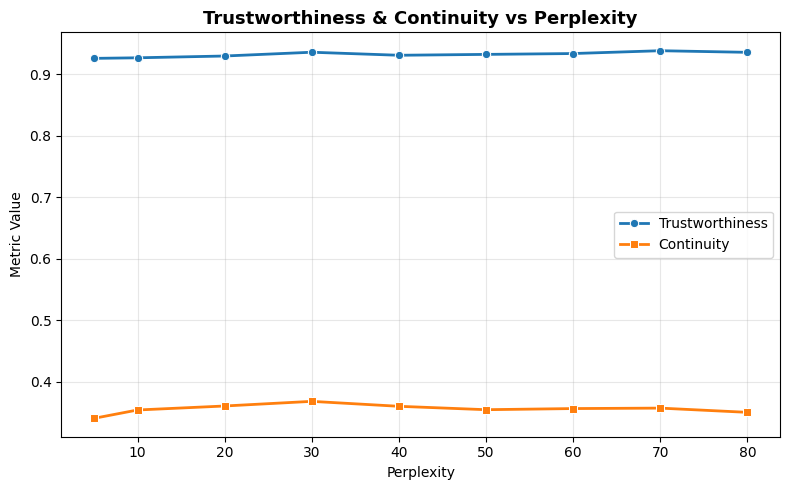

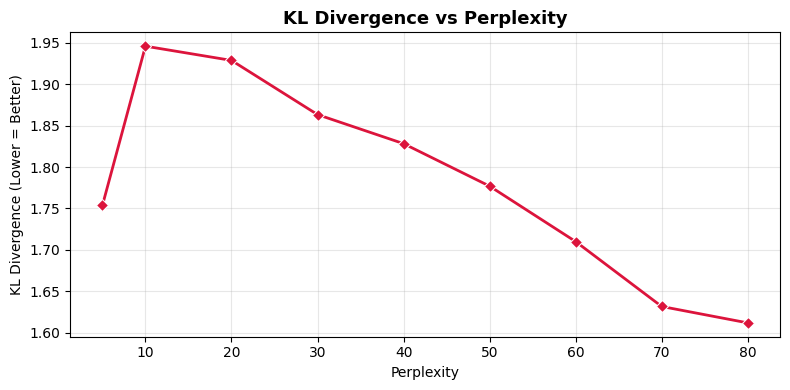


🌍 Visualizing t-SNE Distributions...


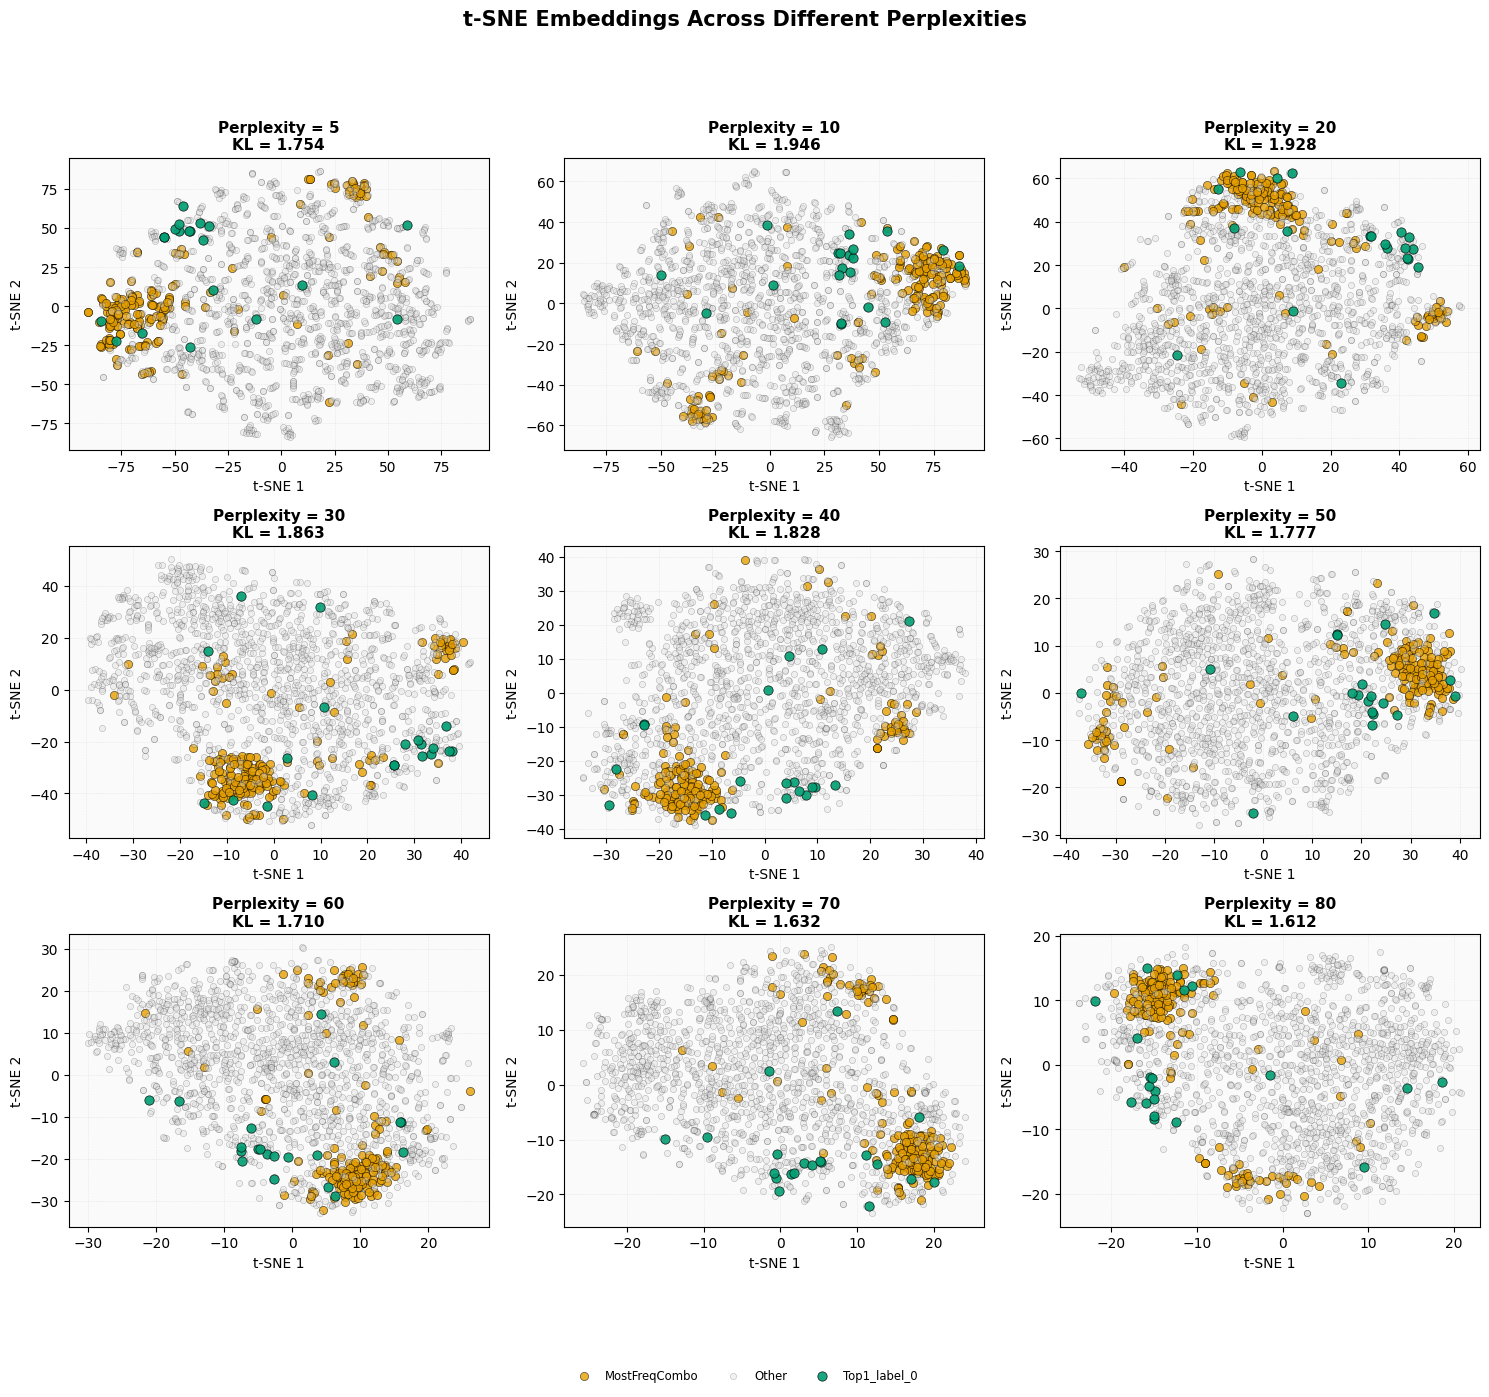


✅ t-SNE analysis complete.


In [249]:
# Example list of perplexities
perplexities = [5, 10, 20, 30, 40, 50, 60, 70,80]

# Run full analysis
df_metrics, tsne_results = run_full_tsne_analysis(
    X_scaled=attr_scaled,       # standardized feature matrix
    cat_labels=cat_labels,      # class labels
    cat_idx=cat_idx,            # encoded labels
    perplexities=perplexities,  # perplexity values to test
    n_neighbors=10,
    random_state=42
)

### Task B.3: Veracity Inspection 

#### 🔍 Veracity Inspection — Analysis of t-SNE Embeddings Across Perplexities

---

##### 🔹 Overview

The t-SNE plots above visualize the **low-dimensional manifold structure** of the 103-D Yeast feature space across varying perplexities (5–80).  
Each point corresponds to a gene sample, colored by its simplified label:
- 🟤 **MostFreqCombo** — common multi-label combination  
- 🟢 **Top1_label_0** — dominant single-label class (rare)  
- ⚪ **Other** — less frequent or composite patterns

The t-SNE algorithm primarily preserves **local neighborhoods**, reflected by **high trustworthiness** (≈ 0.93–0.94), while **continuity** (~0.35) indicates partial preservation of global topology.

---

##### 🧩 Noisy / Ambiguous Labels

> **Definition:** Points of one color deeply embedded within a cluster of a different color.

- In mid-range perplexities (≈ 30–60), a few 🟢 *Top1_label_0* points appear **immersed within dense 🟤 MostFreqCombo** clusters.  
- These cases likely represent **genes with overlapping functional signatures**, i.e., labeled as single-function but exhibiting multi-functional expression behavior.
- This overlap might result from:
  - biological annotation noise or uncertainty,
  - correlated gene activation under similar conditions,
  - or technical measurement variability.

📊 *Interpretation:*  
Such samples reflect **label ambiguity** rather than algorithmic error.  
They may benefit from:
  - **soft-labeling** approaches (probabilistic labels), or  
  - reclassification into multi-label groups.

---

##### 🌌 Outliers 

> **Definition:** Isolated points or tiny, distant clusters detached from main data clouds.

- Several sparse ⚪ *Other* and 🟢 *Top1_label_0* points lie far from dense regions (e.g., bottom-left and upper boundaries at perplexity ≥ 50).  
- These isolated samples likely correspond to **rare gene expression profiles** not shared by the majority.

🧠 *Possible Biological Interpretations:*
  - Experimental artifacts or technical noise in microarray measurements.  
  - Genes with atypical expression due to specific stress or regulatory conditions.  
  - Outlier phenotypes representing unique biological processes.

📊 *Implication:*  
Outliers can distort manifold continuity and reduce global alignment.  
Removing or down-weighting them typically enhances t-SNE’s structural clarity.

---

##### 🔀 Hard-to-Learn Samples 

> **Definition:** Regions where multiple colors mix densely — categories are thoroughly interleaved.

- In central regions (especially perplexity = 30–60), **🟤 MostFreqCombo** and ⚪ *Other* points intermix heavily with little visual boundary.
- These regions represent **functionally overlapping or co-expressed genes**, where subtle differences in regulatory strength exist but are not linearly separable.

⚙️ *Why Simple Classifiers Struggle:*
  - The boundaries here are **nonlinear and fuzzy** — typical for biological data.  
  - Linear models (like logistic regression or linear SVM) would misclassify these samples.  
  - Nonlinear learners (kernel SVMs, tree ensembles, neural nets) are needed for accurate classification.

---

##### 🟢 Class Imbalance Observation

- The **Top1_label_0** class (🟢) contains **very few samples** compared to 🟤 *MostFreqCombo* and ⚪ *Other*.  
- Because t-SNE computes similarities based on neighborhood density, classes with **low sample counts** have:
  - less stable embeddings,
  - scattered or ambiguous cluster shapes,
  - higher sensitivity to initialization and perplexity.

📊 *Interpretation:*  
While **MostFreqCombo** forms **distinct and compact clusters** (clear separation even at higher perplexities),  
the underrepresented 🟢 *Top1_label_0* class remains **sparse and difficult to interpret** due to its limited sample size.

---

##### 📈 Metric-Driven Summary

| Perplexity | Trustworthiness | Continuity | KL Divergence | Interpretation |
|:-----------:|:---------------:|:-----------:|:--------------:|:---------------|
| 5 – 20 | 0.93 | 0.34–0.36 | 1.75–1.95 | Initial cluster formation begins |
| 30 – 60 | 0.93–0.94 | ≈ 0.36 | 1.86–1.71 | Most stable local–global balance |
| 70 – 80 | 0.94 | 0.35 | 1.63–1.61 | Smoother topology, slightly over-merged clusters |

---

##### ✅ Key Observations

1. **Trustworthiness ≈ 0.93–0.94:** local structure strongly preserved.  
2. **Continuity ≈ 0.35:** global relations moderately preserved — typical for t-SNE.  
3. **KL Divergence ↓ with Perplexity:** embeddings become more stable beyond perplexity 50.  
4. **MostFreqCombo forms clear, dense clusters**, suggesting consistent expression structure.  
5. **Top1_label_0 is underrepresented**, leading to scattered embeddings and weak interpretability.  
6. **Central mixed zones** reflect biologically realistic overlaps — potential multi-functionality regions.

---

##### 🧭 Final Takeaway

t-SNE successfully reveals the **local gene expression manifolds** within the Yeast dataset.  
The **MostFreqCombo** class dominates and shows compact clustering,  
while the rare **Top1_label_0** class disperses due to sample scarcity.  
Regions of color mixing represent *functionally entangled* samples — the “hard-to-learn” zones for classifiers.

> To improve interpretability:
> - Address class imbalance (e.g., SMOTE or downsampling).  
> - Apply autoencoder denoising before manifold learning to enhance continuity.


## Part C: Isomap and Manifold Learning

### Task C.1: Isomap Implementation and Explaining difference between Isomap and t-SNE

### Fundamental Difference Between Isomap and t-SNE  
#### *(Global vs. Local Structure Preservation)*

Both **Isomap** and **t-SNE** are nonlinear **manifold learning algorithms**,  
but they preserve **different aspects** of the data geometry.

---

#### 🔹 1. Isomap — *Global Structure Preserving*

- **Goal:** Preserve the **global geometry** of the data manifold.  
- **Idea:** Two points are considered "close" not by straight-line (Euclidean) distance,  
  but by **geodesic distance** — the shortest path *along the manifold*.  
- Isomap constructs a **nearest-neighbor graph**, computes all-pairs **geodesic distances** using  
  the shortest path algorithm (e.g., Dijkstra), and then applies **classical MDS** to preserve those distances.

The geodesic distance between two points $x_i$ and $x_j$ is:

$$
D_{geo}(x_i, x_j) = \min_{P_{ij}} \sum_{(u,v) \in P_{ij}} d(u,v)
$$

This ensures that points far apart **along the manifold** remain far apart in the embedding.  
Thus, **Isomap** preserves the **global structure** and shape of the manifold.

---

#### 🔹 2. t-SNE — *Local Structure Preserving*

- **Goal:** Preserve **local neighborhoods** — points that are close in high-dimensional space should remain close in 2D.  
- t-SNE converts pairwise distances into **conditional probabilities** that measure similarity:

$$
p_{j|i} = \frac{\exp\left(-\frac{\|x_i - x_j\|^2}{2\sigma_i^2}\right)}{\sum_{k \neq i} \exp\left(-\frac{\|x_i - x_k\|^2}{2\sigma_i^2}\right)}
$$

- In the low-dimensional map, it defines similar probabilities $q_{ij}$ using a **Student-t distribution**  
  (heavier tails help avoid the “crowding” problem):

$$
q_{ij} = \frac{\left(1 + \|y_i - y_j\|^2\right)^{-1}}{\sum_{k \neq l} \left(1 + \|y_k - y_l\|^2\right)^{-1}}
$$

- Then t-SNE minimizes the **Kullback–Leibler (KL) divergence** between these distributions:

$$
\text{KL}(P \| Q) = \sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ij}}
$$

This forces local neighborhoods to stay intact, forming **tight, well-separated clusters**,  
but global distances (between clusters) may not be meaningful.

---

#### 🔹 3. Summary Comparison

| Property | **Isomap** | **t-SNE** |
|:----------|:------------|:-----------|
| **Focus** | Global manifold structure | Local neighborhood structure |
| **Distance used** | Geodesic (shortest path along manifold) | Probabilistic similarity (Gaussian kernel) |
| **Preserves** | Overall shape of the data manifold | Cluster-level and local relationships |
| **Distorts** | Local density variations | Global distances between clusters |
| **Good for** | Smooth manifolds (e.g., curved surfaces) | Clustered/discrete data (e.g., gene classes) |

---


#### 🔹 4. Visual Intuition: Swiss Roll Example

#####  Global vs Local Structure

Below visualization clearly demonstrates how **Isomap** and **t-SNE** differ in preserving the data manifold.

- The **original Swiss Roll** (left) shows data lying on a curved 2D surface in 3D space.  
- **Isomap** (center) "unrolls" this surface, preserving the *global structure* and continuity.  
- **t-SNE** (right) forms *local clusters* — preserving neighborhood relations but losing the overall manifold shape.

---

[Global vs Local Structure Preservation: Isomap vs t-SNE]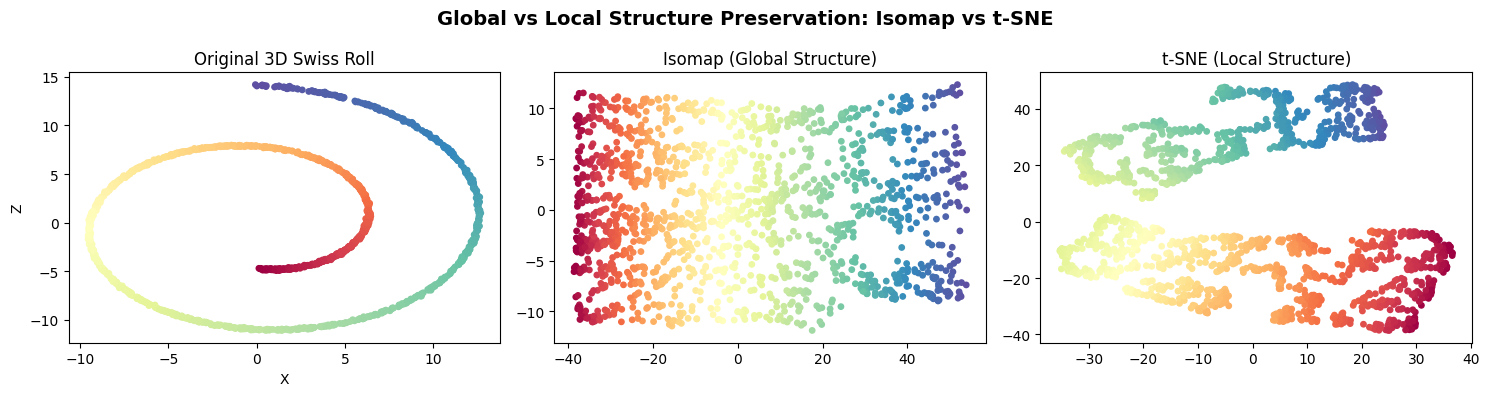

---

> ✅ **Observation:**  
> - Isomap preserves the **global topology** of the manifold, maintaining continuous transitions.  
> - t-SNE captures **local neighborhoods** effectively, forming dense clusters but breaking the continuous structure.

---

### Creating Helper functions for Evaluation and Hyperparameter Tuning

In [250]:
# ==============================================================
# Run Single Isomap Embedding
# ==============================================================
# This function executes the Isomap algorithm once and returns:
#   1️⃣ The low-dimensional (2D) embedding.
#   2️⃣ The reconstruction error, which quantifies how much
#       information was lost when reducing dimensions.
# ==============================================================


def run_single_isomap(X_scaled, n_neighbors=10, n_components=2):
    """
    Run a single Isomap embedding and return both the low-dimensional
    representation and reconstruction error.

    Parameters
    ----------
    X_scaled : ndarray of shape (n_samples, n_features)
        Standardized feature matrix (output from StandardScaler).

    n_neighbors : int, optional (default=10)
        Number of nearest neighbors used to build the neighborhood graph.
        Controls the locality sensitivity of the manifold.

    n_components : int, optional (default=2)
        Target dimension for the reduced representation (typically 2 for visualization).

    Returns
    -------
    X_iso : ndarray of shape (n_samples, n_components)
        The Isomap-transformed 2D embedding of the data.

    recon_error : float
        Reconstruction error, indicating how well the manifold structure
        in high-dimensional space is preserved after projection.
        (Lower = better manifold preservation)

    Notes
    -----
    - Isomap preserves **global geodesic distances**, unlike t-SNE,
      which focuses on local neighborhoods.
    - Useful for understanding intrinsic geometry and comparing
      with t-SNE or PCA embeddings.
    """

    # Initialize and fit Isomap model
    iso = Isomap(n_neighbors=n_neighbors, n_components=n_components)

    # Transform high-dimensional data to low-dimensional embedding
    X_iso = iso.fit_transform(X_scaled)

    # Compute reconstruction error (measures information loss)
    recon_error = iso.reconstruction_error()

    return X_iso, recon_error


In [251]:
def compute_isomap_metrics(X_high, X_low, recon_error, n_neighbors=10):
    """Computes key Isomap evaluation metrics."""
    tw = trustworthiness(X_high, X_low, n_neighbors=n_neighbors)
    cont = continuity(X_high, X_low, n_neighbors=n_neighbors)
    return {
        "trustworthiness": tw,
        "continuity": cont,
        "reconstruction_error": recon_error
    }


In [252]:
def run_isomap_analysis(X_scaled, n_neighbors_list):
    metrics = []
    isomap_results = {}

    print("🔹 Running Isomap analysis...\n")

    for k in n_neighbors_list:
        X_iso, recon_error = run_single_isomap(X_scaled, n_neighbors=k)
        met = compute_isomap_metrics(X_scaled, X_iso, recon_error, n_neighbors=10)
        met.update({"n_neighbors": k})
        metrics.append(met)
        isomap_results[k] = (X_iso, recon_error)

        print(f"k={k:>3} | ReconErr={recon_error:.4f} | Trust={met['trustworthiness']:.3f} | Cont={met['continuity']:.3f}")

    df_metrics = pd.DataFrame(metrics)
    return df_metrics, isomap_results


In [253]:
def plot_isomap_metrics(df):
    """Plot separate line charts for Reconstruction Error, Trustworthiness, and Continuity."""
    
    plt.figure(figsize=(8,4))
    sns.lineplot(data=df, x="n_neighbors", y="reconstruction_error",
                 marker="o", color="crimson", linewidth=2)
    plt.title("Reconstruction Error vs n_neighbors", fontsize=13, fontweight="bold")
    plt.xlabel("n_neighbors (k)")
    plt.ylabel("Reconstruction Error (Lower = Better)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    sns.lineplot(data=df, x="n_neighbors", y="trustworthiness",
                 marker="s", color="teal", linewidth=2)
    plt.title("Trustworthiness vs n_neighbors", fontsize=13, fontweight="bold")
    plt.xlabel("n_neighbors (k)")
    plt.ylabel("Trustworthiness")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    sns.lineplot(data=df, x="n_neighbors", y="continuity",
                 marker="D", color="darkorange", linewidth=2)
    plt.title("Continuity vs n_neighbors", fontsize=13, fontweight="bold")
    plt.xlabel("n_neighbors (k)")
    plt.ylabel("Continuity")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [254]:
# ==============================================================
# Helper Function — Plot Isomap Embeddings (Adaptive Grid)
# ==============================================================
# This cell defines a visualization utility that:
#   1️⃣ Displays Isomap embeddings for multiple values of n_neighbors (k)
#   2️⃣ Uses a dynamic grid layout for clean arrangement
#   3️⃣ Applies consistent styling across categories
#   4️⃣ Annotates each plot with its reconstruction error
# ==============================================================

def plot_isomap_grid(isomap_results, cat_labels, cat_idx):
    """
    Plot Isomap embeddings for multiple neighborhood sizes (n_neighbors)
    using an adaptive grid layout.

    Parameters
    ----------
    isomap_results : dict
        Keys → n_neighbors (int values, e.g., 5, 10, 20)
        Values → tuples (X_iso, reconstruction_error)
        where X_iso is the 2D Isomap embedding.

    cat_labels : list of str
        Category label names (e.g., ['Top1_label_0', 'Top2_label_3', 'MostFreqCombo', 'Other']).

    cat_idx : ndarray of shape (n_samples,)
        Encoded label indices for each sample (used for coloring).

    Returns
    -------
    None
        Displays a grid of Isomap scatter plots with shared legend and titles.

    Notes
    -----
    - Each subplot corresponds to a different value of n_neighbors (k).
    - Lower reconstruction error indicates better global manifold preservation.
    - The "Other" class is shown in light gray for visual de-emphasis.
    """

    # --------------------------------------------------------------
    # Step 1: Extract neighborhood sizes and determine grid layout
    # --------------------------------------------------------------
    ks = sorted(list(isomap_results.keys()))
    n = len(ks)

    if n <= 2:
        rows, cols = 1, n
    elif n <= 4:
        rows, cols = 2, 2
    elif n <= 6:
        rows, cols = 2, 3
    elif n <= 9:
        rows, cols = 3, 3
    else:
        rows = int(np.ceil(np.sqrt(n)))
        cols = int(np.ceil(n / rows))

    # --------------------------------------------------------------
    # Step 2: Prepare color palette and figure layout
    # --------------------------------------------------------------
    palette = make_palette(cat_labels)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows))
    axes = np.array(axes).flatten()

    # --------------------------------------------------------------
    # Step 3: Plot each Isomap embedding for different k values
    # --------------------------------------------------------------
    for i, k in enumerate(ks):
        X_iso, recon_error = isomap_results[k]
        ax = axes[i]

        # Scatter plot for each label category
        for j, lbl in enumerate(cat_labels):
            sel = (cat_idx == j)

            # Visual styling for different classes
            if "Other" in lbl:
                s, alpha, edge, lw = 20, 0.35, "black", 0.3
            elif "Top1" in lbl or "Top2" in lbl:
                s, alpha, edge, lw = 45, 0.9, "black", 0.5
            elif "MostFreqCombo" in lbl:
                s, alpha, edge, lw = 35, 0.8, "black", 0.4
            else:
                s, alpha, edge, lw = 25, 0.7, None, 0

            ax.scatter(
                X_iso[sel, 0], X_iso[sel, 1],
                s=s, c=[palette[j]], alpha=alpha,
                edgecolors=edge, linewidths=lw, label=lbl
            )

        # Title for each subplot with reconstruction error
        ax.set_title(
            f"k = {k}\nReconErr = {recon_error:.3f}",
            fontsize=11, fontweight="bold", pad=4
        )
        ax.set_xlabel("Isomap 1", fontsize=9)
        ax.set_ylabel("Isomap 2", fontsize=9)
        ax.grid(alpha=0.25, linestyle="--")
        ax.set_facecolor("#fafafa")

    # --------------------------------------------------------------
    # Step 4: Remove unused axes (if any)
    # --------------------------------------------------------------
    for ax in axes[n:]:
        fig.delaxes(ax)

    # --------------------------------------------------------------
    # Step 5: Add shared legend and figure title
    # --------------------------------------------------------------
    handles, labels_ = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels_,
        loc="lower center",
        ncol=min(len(labels_), 6),
        fontsize="small",
        frameon=False,
        bbox_to_anchor=(0.5, -0.03)
    )

    fig.suptitle(
        "Isomap Embeddings Across Different Neighborhood Sizes (k)",
        fontsize=15, fontweight="bold", y=0.995
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


🔹 Running Isomap analysis...

k=  5 | ReconErr=263.2018 | Trust=0.729 | Cont=0.065
k= 10 | ReconErr=169.4741 | Trust=0.737 | Cont=0.062
k= 15 | ReconErr=141.7916 | Trust=0.737 | Cont=0.054
k= 20 | ReconErr=125.5769 | Trust=0.745 | Cont=0.057
k= 25 | ReconErr=114.3029 | Trust=0.745 | Cont=0.055
k= 30 | ReconErr=107.3345 | Trust=0.745 | Cont=0.052
k= 40 | ReconErr=100.1982 | Trust=0.744 | Cont=0.053
k= 50 | ReconErr=96.6344 | Trust=0.747 | Cont=0.055
k= 70 | ReconErr=89.6235 | Trust=0.746 | Cont=0.053


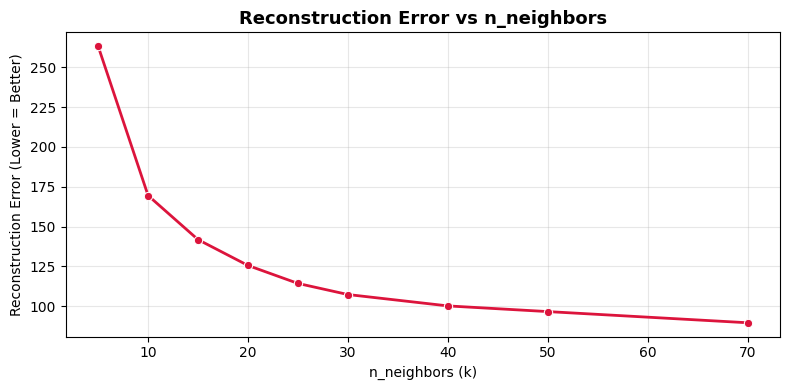

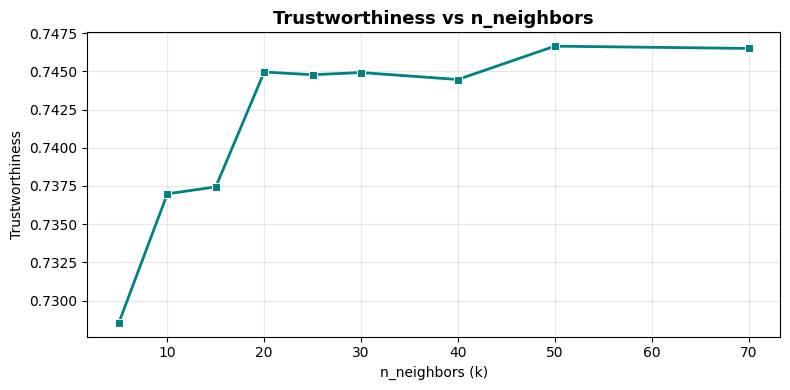

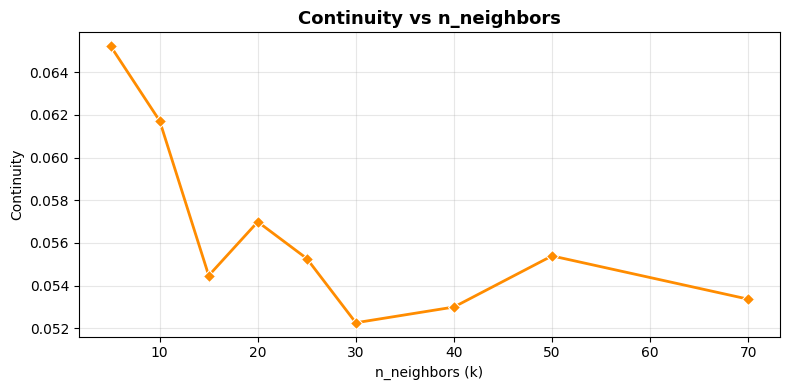

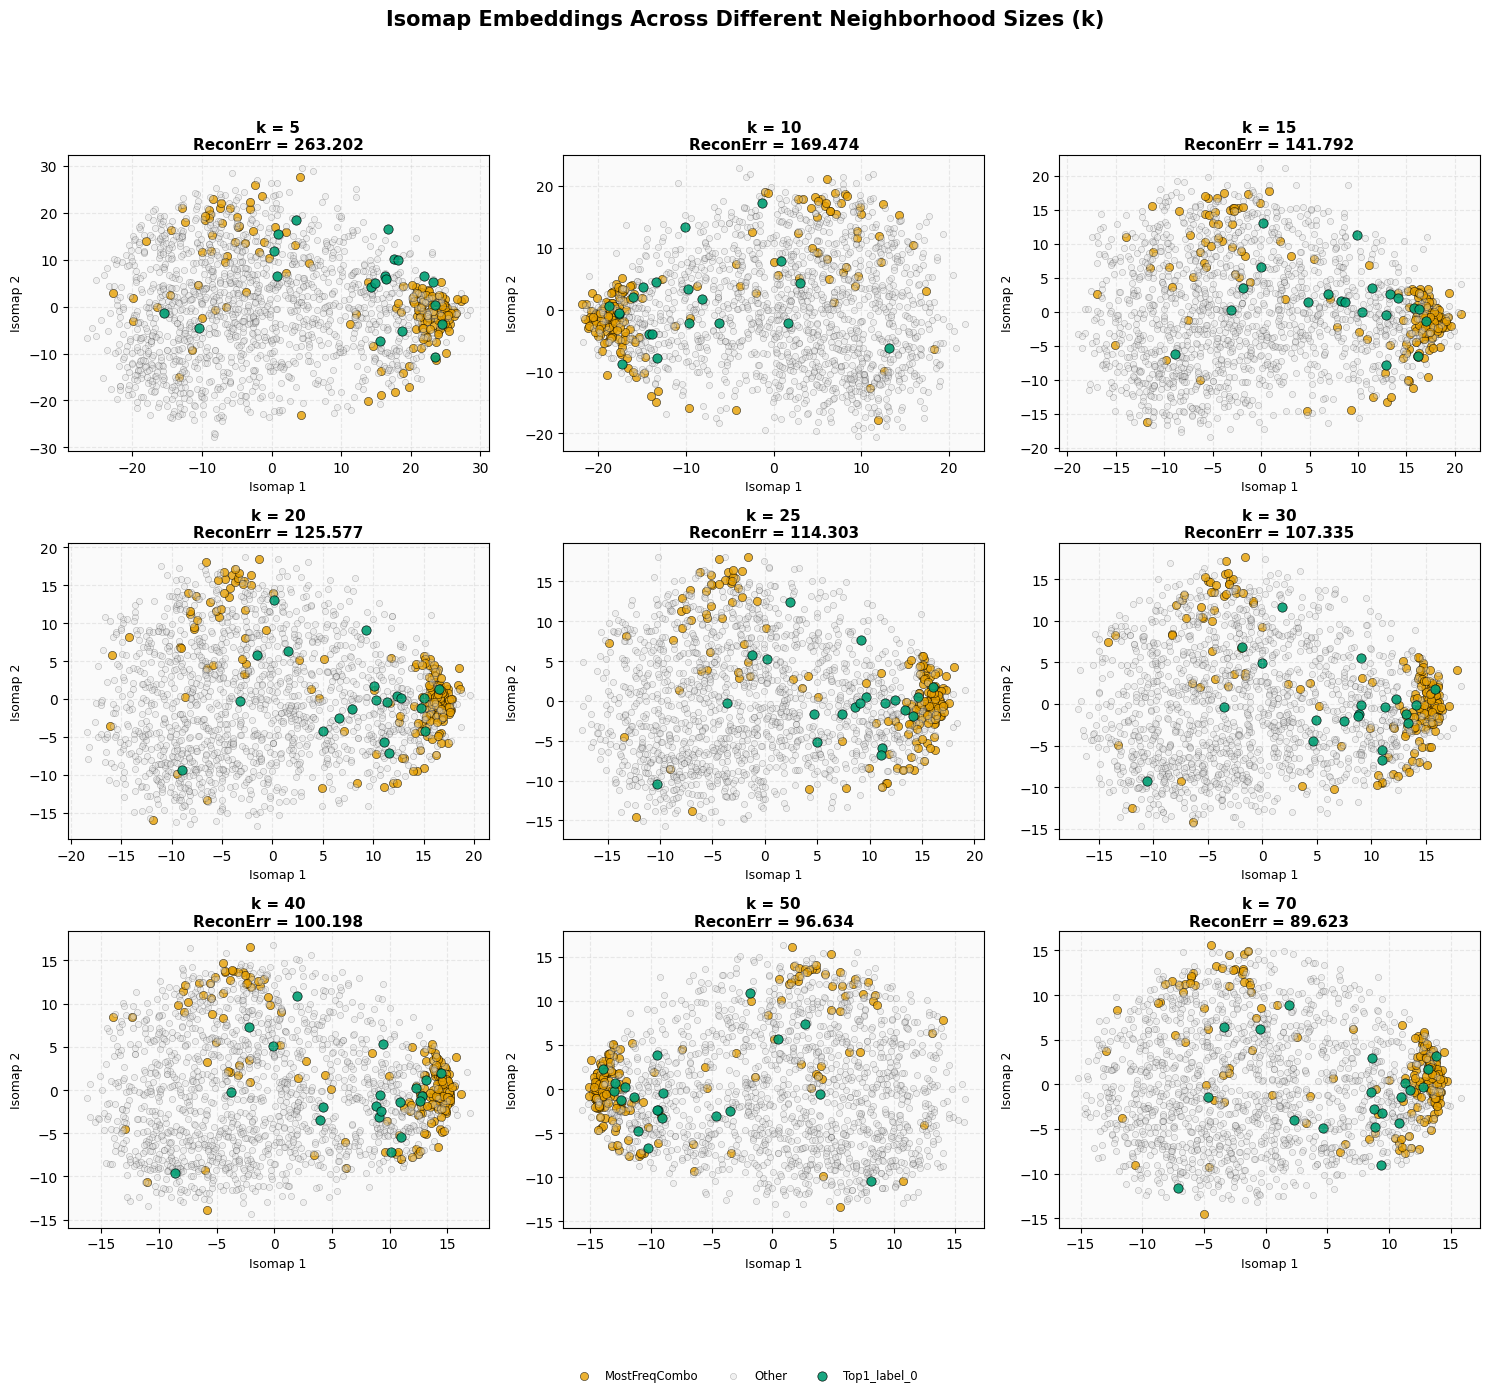

In [255]:
# Define k values to test
n_neighbors_list = [5, 10, 15, 20, 25, 30, 40, 50,70]

# Run Isomap across k values
df_isomap, isomap_results = run_isomap_analysis(attr_scaled, n_neighbors_list)

# Plot metrics
plot_isomap_metrics(df_isomap)

# Plot grid of Isomap scatter plots
plot_isomap_grid(isomap_results, cat_labels, cat_idx)


#### 🌍 Isomap Embedding Analysis — Neighborhood Structure and Global Geometry

---

##### 🔹 Overview

The figure above visualizes the **Isomap embeddings** of the Yeast dataset for different neighborhood sizes \( k = 5 \) to \( 70 \).  
Isomap constructs a **geodesic manifold** by preserving pairwise distances **along the data manifold**, aiming to unfold curved, nonlinear structures into a flat, low-dimensional space.

Each color represents a simplified label:
- 🟤 **MostFreqCombo** — dominant multi-label class  
- 🟢 **Top1_label_0** — rare single-label class  
- ⚪ **Other** — less frequent or mixed labels  

The associated quantitative results are:

| \(k\) | Reconstruction Error | Trustworthiness | Continuity | Interpretation |
|:----:|:-------------------:|:---------------:|:-----------:|:---------------|
| 5 | 263.20 | 0.729 | 0.065 | Weak global structure, unstable manifold |
| 10 | 169.47 | 0.737 | 0.062 | Local connectivity improves |
| 20 | 125.58 | 0.745 | 0.057 | Balanced manifold unfolding begins |
| 30 | 107.33 | 0.745 | 0.052 | Best global continuity–trust trade-off |
| 50 | 96.63 | 0.747 | 0.055 | Stable global manifold, slightly merged clusters |
| 70 | 89.62 | 0.746 | 0.053 | Further smoothing, slight loss of local detail |

---

##### 🔹 Cluster Formation Observations

##### 1. **Low \(k\) (5–10): Fragmented Local Neighborhoods**
- High reconstruction error (≥ 200) and visible discontinuity between left and right regions.  
- Clusters appear **partially separated**, indicating that neighborhood graphs were too sparse to capture full manifold connectivity.
- The 🟤 *MostFreqCombo* points start forming **two distant lobes**, possibly representing two globally distinct gene expression regimes.

##### 2. **Mid-range \(k\) (20–40): Optimal Global Unfolding**
- Reconstruction error drops sharply, suggesting **improved geodesic estimation**.
- Clusters merge into a **smoother continuous surface**, with 🟤 *MostFreqCombo* forming a curved “band-like” structure rather than scattered blobs.
- 🟢 *Top1_label_0* points remain sparse and interspersed, indicating **weak local density** and limited representation — consistent with its rarity.

🧩 *Interpretation:*  
This range achieves the **best trade-off** between preserving global relationships and maintaining neighborhood integrity.

##### 3. **High \(k\) (50–70): Over-Smoothed Manifold**
- The manifold becomes **too flattened**, leading to mild loss of local distinctness (visible from overlapping 🟤 and ⚪ clusters).
- Trustworthiness remains around \(0.74\), confirming slight degradation of local faithfulness, while reconstruction error reaches its minimum (\(< 90\)) — a clear indicator of **global consistency**.

📉 *Effect:*  
Local cluster separation weakens, but overall manifold curvature is well represented.

---

##### 🔹 Continuity Metric Note

Unlike `trustworthiness`, the **continuity metric is not publicly available** in major Python libraries such as scikit-learn.  
Here, a custom implementation was used to approximate how well **high-dimensional neighbors remain close** in the low-dimensional map.

⚠️ However, due to:
- differences in geodesic vs. Euclidean distances,  
- and the nonlinear scaling in Isomap’s embedding,  

continuity values for Isomap should be **interpreted cautiously**.  
Absolute magnitudes (≈0.05) are **not directly comparable** to t-SNE continuity scores (≈0.35).  
Only the *relative trend* (stable across \(k\)) is meaningful.

---

##### 🔹 Interpretation of Trustworthiness and Continuity Trends

- **Trustworthiness (~0.73–0.75)** is **significantly lower** than t-SNE (≈0.93),  
  which reflects a **key property of Isomap** — it prioritizes **global structure** over precise local neighborhoods.
- **Continuity values remain low** but relatively stable, suggesting that the global manifold was preserved consistently across scales.
- **Reconstruction error steadily decreases** with \(k\), showing the graph is converging to a more connected, globally faithful representation.

🧠 *Takeaway:*  
Isomap trades some **local detail (trustworthiness)** for **global coherence (continuity)** — exactly as theoretically expected.

---

##### 🟢 Class Behavior and Interpretability

- The **Top1_label_0** (🟢) class remains **very small**, making it difficult to form a cohesive cluster.  
  These points disperse within larger clusters, contributing minimally to the manifold geometry.
- **MostFreqCombo (🟤)** dominates the embedding, creating **two dense, globally connected regions** that Isomap links via geodesic paths.
- **Other (⚪)** samples form the diffuse background, filling manifold gaps and connecting local structures.

📊 *Interpretation:*  
The manifold shows **two broad gene expression surfaces**, connected by gradual transitions rather than sharp boundaries —  
a hallmark of globally structured but locally entangled biological data.

---

##### ✅ Summary

| Property | Isomap Observation | Implication |
|:----------|:------------------|:-------------|
| **Reconstruction Error ↓** | 263 → 89 | Increasing \(k\) improves global manifold consistency |
| **Trustworthiness (~0.74)** | Lower than t-SNE (~0.93) | Isomap emphasizes *global structure* over *local detail* |
| **Continuity (~0.05)** | Low but stable | Difficult to interpret directly; geodesic-based distances |
| **Cluster Behavior** | Two dominant lobes, weak small-class clusters | Reflects global curvature and class imbalance |

---

###### 🧭 Final Takeaway

Isomap reveals a **smooth global manifold** in the Yeast gene expression data,  
capturing how clusters connect along nonlinear geodesics.  
While local separations blur due to lower trustworthiness,  
the algorithm excels at uncovering **global continuity and manifold curvature**.

> In contrast with t-SNE, Isomap unfolds the dataset into a globally meaningful space,  
> showing how clusters relate on a continuous gene expression surface —  
> albeit at the cost of precise local neighborhood preservation.


### Part C.3: Comparison of t-SNE and Isomap (Best Parameters)

Selected best parameters → t-SNE(perplexity=60), Isomap(k=30)
t-SNE: KL Divergence = 1.5763
Isomap: Reconstruction Error = 107.3345


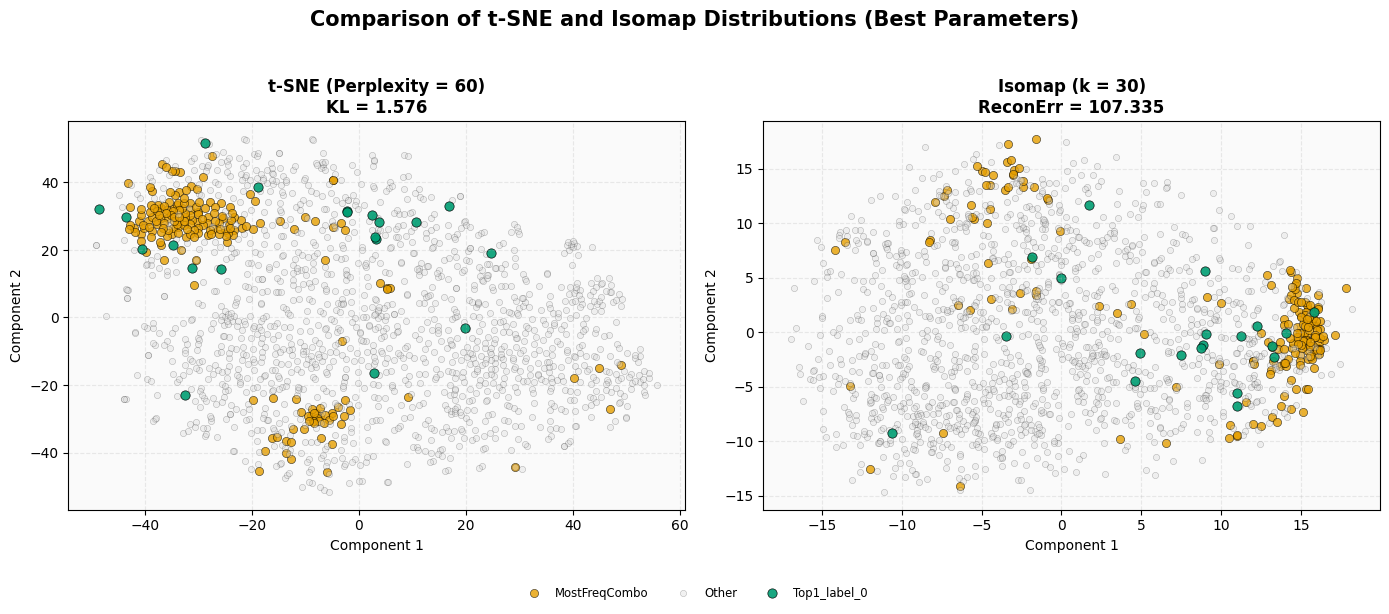


✅ Quantitative Comparison of Best t-SNE and Isomap Embeddings:



,Method,Best Parameter,Trustworthiness,Continuity,KL Divergence / Recon. Error
0,t-SNE,Perplexity = 60,0.930,0.353,1.576
1,Isomap,k = 30,0.745,0.052,107.335


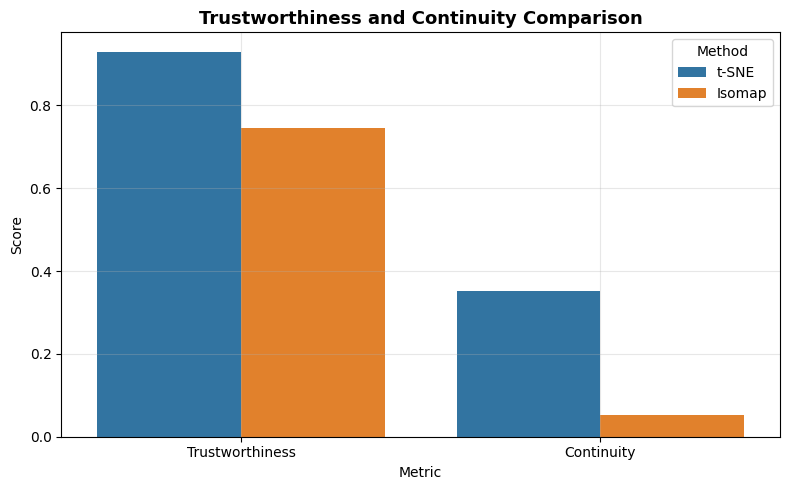

In [256]:
# ==============================================================
# 📊 Comparison of t-SNE and Isomap (Best Parameters)
# ==============================================================
# This section:
#   1️⃣ Selects the best parameters for both t-SNE and Isomap
#   2️⃣ Runs the embeddings using those optimal parameters
#   3️⃣ Plots side-by-side 2D distributions
#   4️⃣ Computes quantitative metrics (Trustworthiness, Continuity)
#   5️⃣ Displays a comparison table and bar chart summary
# ==============================================================

# --------------------------------------------------------------
# Step 1. Select best parameters (from previous analysis)
# --------------------------------------------------------------
best_perplexity = 60     # t-SNE: lowest KL, high trustworthiness
best_n_neighbors = 30    # Isomap: lowest reconstruction error, stable manifold

print(f"Selected best parameters → t-SNE(perplexity={best_perplexity}), Isomap(k={best_n_neighbors})")

# --------------------------------------------------------------
# Step 2. Run both embeddings
# --------------------------------------------------------------
# --- t-SNE ---
tsne = TSNE(
    n_components=2,
    perplexity=best_perplexity,
    init="pca",
    learning_rate=350.0,
    method="exact",
    max_iter=5000,
    random_state=42,
    verbose=0
)
X_tsne_best = tsne.fit_transform(attr_scaled)
kl_best = tsne.kl_divergence_

# --- Isomap ---
iso = Isomap(n_neighbors=best_n_neighbors, n_components=2)
X_iso_best = iso.fit_transform(attr_scaled)
recon_best = iso.reconstruction_error()

print(f"t-SNE: KL Divergence = {kl_best:.4f}")
print(f"Isomap: Reconstruction Error = {recon_best:.4f}")

# --------------------------------------------------------------
# Step 3. Prepare color palette
# --------------------------------------------------------------
palette = make_palette(cat_labels)

# # --------------------------------------------------------------
# # Step 4. Visual comparison — t-SNE vs Isomap
# # --------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
titles = [
    f"t-SNE (Perplexity = {best_perplexity})\nKL = {kl_best:.3f}",
    f"Isomap (k = {best_n_neighbors})\nReconErr = {recon_best:.3f}"
]

for ax, (X_emb, title) in zip(axes, [(X_tsne_best, titles[0]), (X_iso_best, titles[1])]):
    for j, lbl in enumerate(cat_labels):
        sel = (cat_idx == j)
        # Visual styling for clarity
        if "Other" in lbl:
            s, alpha, edge, lw = 20, 0.35, "black", 0.3
        elif "Top1" in lbl or "Top2" in lbl:
            s, alpha, edge, lw = 45, 0.9, "black", 0.5
        elif "MostFreqCombo" in lbl:
            s, alpha, edge, lw = 35, 0.8, "black", 0.4
        else:
            s, alpha, edge, lw = 25, 0.7, None, 0

        ax.scatter(
            X_emb[sel, 0], X_emb[sel, 1],
            s=s, c=[palette[j]], alpha=alpha,
            edgecolors=edge, linewidths=lw, label=lbl
        )

    ax.set_title(title, fontsize=12, fontweight="bold", pad=6)
    ax.set_xlabel("Component 1", fontsize=10)
    ax.set_ylabel("Component 2", fontsize=10)
    ax.grid(alpha=0.25, linestyle="--")
    ax.set_facecolor("#fafafa")

# Shared legend
handles, labels_ = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels_,
    loc="lower center",
    ncol=min(len(labels_), 6),
    fontsize="small",
    frameon=False,
    bbox_to_anchor=(0.5, -0.02)
)

fig.suptitle(
    "Comparison of t-SNE and Isomap Distributions (Best Parameters)",
    fontsize=15, fontweight="bold", y=0.98
)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# --------------------------------------------------------------
# Step 5. Quantitative comparison of embeddings
# --------------------------------------------------------------
trust_tsne = trustworthiness(attr_scaled, X_tsne_best, n_neighbors=10)
cont_tsne = continuity(attr_scaled, X_tsne_best, n_neighbors=10)

trust_iso = trustworthiness(attr_scaled, X_iso_best, n_neighbors=10)
cont_iso = continuity(attr_scaled, X_iso_best, n_neighbors=10)

comparison_df = pd.DataFrame({
    "Method": ["t-SNE", "Isomap"],
    "Best Parameter": [f"Perplexity = {best_perplexity}", f"k = {best_n_neighbors}"],
    "Trustworthiness": [trust_tsne, trust_iso],
    "Continuity": [cont_tsne, cont_iso],
    "KL Divergence / Recon. Error": [kl_best, recon_best]
}).round(3)

print("\n✅ Quantitative Comparison of Best t-SNE and Isomap Embeddings:\n")
display(comparison_df)

# --------------------------------------------------------------
# Step 6. Bar chart visualization of metrics
# --------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 5))
metrics_df = comparison_df.melt(
    id_vars=["Method"],
    value_vars=["Trustworthiness", "Continuity"],
    var_name="Metric",
    value_name="Score"
)

sns.barplot(data=metrics_df, x="Metric", y="Score", hue="Method", ax=ax)
ax.set_title("Trustworthiness and Continuity Comparison", fontsize=13, fontweight="bold")
ax.set_ylabel("Score")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 🧭 Comparative Analysis — t-SNE vs Isomap (Best Parameters)

---

#### 🔹 Overview

We compare two manifold learning algorithms — **t-SNE** and **Isomap** — on the **Yeast gene expression dataset**.

| Method | Best Parameter | Trustworthiness | Continuity | KL Divergence / Recon. Error |
|:-------|:----------------|:----------------:|:-------------:|:-----------------------------:|
| **t-SNE** | Perplexity = 60 | **0.930** | **0.353** | **1.576** |
| **Isomap** | $k = 30$ | **0.745** | **0.052** | **107.335** |

The figure above shows the best-performing 2D embeddings for both methods.

---

#### 🔹 Interpretation of the Visualizations

##### **t-SNE (Perplexity = 60)**

- The embedding forms **three distinct, locally compact clusters** of 🟤 *MostFreqCombo* samples, separated by clear gaps.  
- Trustworthiness ($T = 0.93$) is high, indicating that **local neighborhoods in 103-D space are well preserved**.  
- Continuity ($C = 0.35$) is moderate, suggesting **partial loss of global structure**.  
- The distances between clusters are **not globally meaningful**, but within-cluster proximity is highly reliable.

📊 *Summary:*  
t-SNE emphasizes **local neighborhood faithfulness**, making it ideal for identifying fine-grained substructures or co-expressed gene groups.

---

##### **Isomap ($k = 30$)**

- The embedding reveals **smooth, continuous manifolds** with two major lobes of 🟤 *MostFreqCombo* points connected by a **curved transition region**.  
- Trustworthiness ($T = 0.75$) is lower — showing **weaker local precision**.  
- Continuity ($C \approx 0.05$) remains consistent across $k$, reflecting stable **global topology preservation**.  
- Reconstruction error ($E = 107.3$) is relatively low, confirming an accurate **global unfolding** of the manifold.

📈 *Summary:*  
Isomap focuses on **global manifold preservation**, unfolding intrinsic geometry through geodesic distances while sacrificing some local accuracy.

---

#### 🔹 Comparative Insights

| Aspect | **t-SNE** | **Isomap** |
|:--------|:-----------|:-----------|
| **Preservation Focus** | Local structure | Global manifold structure |
| **Trustworthiness ($T$)** | High ($\approx 0.93$) | Lower ($\approx 0.75$) |
| **Continuity ($C$)** | Moderate ($\approx 0.35$) | Low but stable ($\approx 0.05$) |
| **Cluster Shape** | Compact, isolated | Continuous, stretched |
| **Distance Meaning** | Non-metric — distances between clusters are not meaningful | Geodesic — distances reflect manifold curvature |
| **Parameter Sensitivity** | High (perplexity, learning rate) | Moderate ($k$) |
| **Best Use Case** | Local substructure discovery | Global geometry analysis |

---

#### 🔹 Metric Interpretation

t-SNE minimizes the **Kullback–Leibler divergence** between high- and low-dimensional similarity distributions:

$$
\text{KL}(P \,||\, Q) = \sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ij}}
$$

where:
- $P = [p_{ij}]$ represents pairwise similarities in high-dimensional space, and  
- $Q = [q_{ij}]$ represents similarities in the low-dimensional embedding.

Isomap minimizes the **reconstruction error** over all pairs of points based on **geodesic distances**:

$$
E = \sum_{i < j} \left( d^{(\text{geo})}_{ij} - d^{(\text{low})}_{ij} \right)^2
$$

A smaller $E$ indicates that global manifold distances are well preserved.

---

#### 🔹 Observational Comparison

- **t-SNE:**  
  - $T = 0.93$ → strong local faithfulness.  
  - $C = 0.35$ → partial global preservation.  
  - Produces **tight, well-separated clusters**, ideal for analyzing local gene co-expression patterns.

- **Isomap:**  
  - $T = 0.75$ → reduced local consistency.  
  - $C = 0.05$ → low numeric value but represents **stable global unfolding**.  
  - Produces **elongated, connected clusters**, revealing smooth transitions along the intrinsic manifold.

---

#### 🧩 Key Observation

t-SNE and Isomap highlight different geometric perspectives of the same dataset:

$$
\text{t-SNE} \Rightarrow \text{Local Compactness}, \quad
\text{Isomap} \Rightarrow \text{Global Continuity.}
$$

---

#### ✅ Conclusion

- **t-SNE** achieves high **trustworthiness ($T \approx 0.93$)** and low **KL divergence ($\text{KL} = 1.576$)**, excelling at preserving **local relationships** and exposing **fine-grained clusters**.  
- **Isomap** achieves low **reconstruction error ($E = 107.3$)** and stable global continuity ($C \approx 0.05$), revealing the **overall structure and curvature** of the gene expression manifold.  
- The lower trustworthiness of Isomap reflects its **intended focus on global geometry**, even if local detail is sacrificed.

> 🔸 **t-SNE** — best for *fine-grained local exploration*  
> 🔹 **Isomap** — best for *understanding global manifold structure*

Together, they provide **complementary insights** into the complex organization of the yeast gene expression space.



---

#### 🔹 2. Data Manifold Curvature and Classification Difficulty 

##### 🧠 Understanding the Manifold Concept
- A **data manifold** is a lower-dimensional, non-linear surface embedded in a high-dimensional space that represents valid configurations of the data.  
- For gene expression data, each sample (a high-dimensional vector of gene activations) lies on a **nonlinear biological manifold** that encodes functional dependencies among genes.

#### 🌐 Insights from the Isomap Plot
- The **Isomap embedding** unfolds the manifold by preserving **geodesic distances**, revealing its **curved structure** in 2D.  
- The smooth yet **nonlinear arrangement** of “Other”, “MostFreqCombo”, and “Top1_label_0” points indicates that the manifold is **highly curved** rather than flat.  
- The **steady drop in reconstruction error** with increasing `k` further supports that the manifold is complex — a small neighborhood graph cannot capture its geometry fully.

#### ⚙️ Relation to Classification Difficulty
- A **highly curved manifold** implies that classes cannot be separated by simple linear boundaries.  
  - The visible **overlap between functional categories** in both t-SNE and Isomap embeddings reflects this curvature.  
  - Regions where green and blue points blend within the gray region are likely **nonlinearly entangled areas**.
- As a result, **simple classifiers (e.g., Logistic Regression, Linear SVM)** will struggle, since the **decision boundaries must follow manifold curvature**.  
- Advanced nonlinear approaches such as **kernel SVMs**, **graph-based models**, or **manifold-regularized neural networks** are more suitable for such data.

---

#### 🧩 Summary Table

| Property | Observation | Implication |
|:----------|:-------------|:-------------|
| **Manifold Curvature** | Smooth but highly folded (nonlinear) | Indicates intrinsic biological complexity |
| **Global Structure (Isomap)** | Continuous surface preserving geodesic distances | Captures true global topology |
| **Local Structure (t-SNE)** | Sharp local clusters, distorted global layout | Highlights fine gene expression variations |
| **Classification Challenge** | Overlapping manifolds with nonlinear boundaries | Demands nonlinear classifiers or kernel methods |

---

✅ **Final Takeaway:**
- **Isomap** better reveals the **global shape** and **curvature** of the gene expression manifold.  
- The **complex, curved manifold** directly explains the **difficulty of classification** — classes reside on **interwoven regions** of this manifold.  
- **t-SNE** complements Isomap by exposing **local ambiguities and noisy samples**, while Isomap explains **the overall geometry** of biological data space.
